# Imports

In [4]:
import os
import struct
import datetime
# from skfda import FDataGrid
# from skfda.preprocessing.dim_reduction import FPCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter1d
import torch.nn as nn
import splitfolders
from tensorflow.keras.models import load_model
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import random
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np4
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Finished Data Processing Functions

In [5]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 61, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 61)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

peak_finding_model = CNN()
model_loader = torch.load('./models/waveI_cnn_model.pth')
peak_finding_model.load_state_dict(model_loader)
peak_finding_model.eval()

def peak_finding(wave):
    # Prepare waveform
    waveform=interpolate_and_smooth(wave) # Added indexing per calculate and plot wave function
    # waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0) archived ABRA
    waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0) #newer ABRA
    # print(waveform_torch)
    # Get prediction from model
    outputs = peak_finding_model(waveform_torch)
    prediction = int(round(outputs.detach().numpy()[0][0], 0))
    # prediction_test = int(round(outputs.detach().numpy()[0], 0))
    # print("Model output:", outputs, "Prediction true start:", prediction)

    # Apply Gaussian smoothing
    smoothed_waveform = gaussian_filter1d(waveform, sigma=1)

    # Find peaks and troughs
    n = 18
    t = 14
    # start_point = prediction - 9 archived ABRA
    start_point = prediction - 6 #newer ABRA
    smoothed_peaks, _ = find_peaks(smoothed_waveform[start_point:], distance=n)
    smoothed_troughs, _ = find_peaks(-smoothed_waveform, distance=t)
    sorted_indices = np.argsort(smoothed_waveform[smoothed_peaks+start_point])
    highest_smoothed_peaks = np.sort(smoothed_peaks[sorted_indices[-5:]] + start_point)
    relevant_troughs = np.array([])
    for p in range(len(highest_smoothed_peaks)):
        c = 0
        for t in smoothed_troughs:
            if t > highest_smoothed_peaks[p]:
                if p != 4:
                    try:
                        if t < highest_smoothed_peaks[p+1]:
                            relevant_troughs = np.append(relevant_troughs, int(t))
                            break
                    except IndexError:
                        pass
                else:
                    relevant_troughs = np.append(relevant_troughs, int(t))
                    break
    relevant_troughs = relevant_troughs.astype('i')
    return highest_smoothed_peaks, relevant_troughs

In [6]:
import pandas as pd
import io
import re

def extract_metadata(metadata_lines):
    # Dictionary to store extracted metadata
    metadata = {}
    
    for line in metadata_lines:
        # Extract SW FREQ
        freq_match = re.search(r'SW FREQ:\s*(\d+\.?\d*)', line)
        if freq_match:
            metadata['SW_FREQ'] = float(freq_match.group(1))
        
        # Extract LEVELS
        levels_match = re.search(r':LEVELS:\s*([^:]+)', line)
        if levels_match:
            # Split levels and convert to list of floats
            metadata['LEVELS'] = [float(level) for level in levels_match.group(1).split(';') if level]
    
    return metadata

def read_custom_tsv(file_path):
    # Read the entire file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        content = f.read()
    
    # Split the content into metadata and data sections
    metadata_lines = []
    data_section = None
    
    # Find the ':DATA' marker
    data_start = content.find(':DATA')
    
    if data_start != -1:
        # Extract metadata (lines before ':DATA')
        metadata_lines = content[:data_start].split('\n')
        
        # Extract data section
        data_section = content[data_start:].split(':DATA')[1].strip()
    
    # Extract specific metadata
    metadata = extract_metadata(metadata_lines)
    
    # Read the data section directly
    try:
        # Use StringIO to create a file-like object from the data section
        raw_data = pd.read_csv(
            io.StringIO(data_section), 
            sep='\s+',  # Use whitespace as separator
            header=None
        )
        raw_data = raw_data.T
        # Add metadata columns to the DataFrame
        if 'SW_FREQ' in metadata:
            raw_data['Freq(Hz)'] = metadata['SW_FREQ']
            raw_data['Freq(Hz)'] = raw_data['Freq(Hz)'].apply(lambda x: x*1000)
        
        if 'LEVELS' in metadata:
            # Repeat levels to match the number of rows
            levels_repeated = metadata['LEVELS'] * (len(raw_data) // len(metadata['LEVELS']) + 1)
            raw_data['Level(dB)'] = levels_repeated[:len(raw_data)]
        
        filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()
        filtered_data.columns = filtered_data.columns.map(str)

        columns = ['Freq(Hz)'] + ['Level(dB)'] + [col for col in filtered_data.columns if col.isnumeric() == True]
        filtered_data = filtered_data[columns]
        return filtered_data
    
    except Exception as e:
        print(f"Error reading data: {e}")
        return None, metadata

# Use the function
# abr_test = "/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/wpz_104L/11_3/ABR-104-L-11.3.tsv"
# raw_data = read_custom_tsv(abr_test)

In [7]:
def get_str(data):
    # return string up until null character only
    ind = data.find(b'\x00')
    if ind > 0:
        data = data[:ind]
    return data.decode('utf-8')

def interpolate_and_smooth(final, target_length=244): # To implement after moving beyond Manor data since we already have 244 time points
    if len(final) > target_length:
        new_points = np.linspace(0, len(final), target_length + 2)
        interpolated_values = np.interp(new_points, np.arange(len(final)), final)
        final = np.array(interpolated_values[:target_length], dtype=float)
    elif len(final) < target_length:
        original_indices = np.arange(len(final))
        target_indices = np.linspace(0, len(final) - 1, target_length)
        cs = CubicSpline(original_indices, final)
        final = cs(target_indices)
    return final

In [8]:
def peaks_troughs_amp_final(df, freq, db, time_scale=10):
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        y_values = interpolate_and_smooth(final, target)  # Original y-values for plotting
        sampling_rate = len(y_values) / time_scale

        x_values = np.linspace(0, len(y_values) / sampling_rate, len(y_values))

        y_values = interpolate_and_smooth(final[:244])

        fpf = df[(df['Freq(Hz)'] == freq)].loc[:, '0':]

        # Flatten the data to scale all values across the group
        flattened_data = fpf.values.flatten().reshape(-1, 1)

        # Step 1: Standardize the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)

        # Step 2: Apply min-max scaling
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(fpf.shape)

        # Reshape back to the original shape and update the group
        fpf[fpf.columns] = scaled_data

        finalfpf = fpf.loc[index, '0':].dropna()
        finalfpf = pd.to_numeric(finalfpf, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        y_values_fpf = interpolate_and_smooth(finalfpf, target)  # Original y-values for plotting
        sampling_rate = len(y_values) / time_scale

        y_values_fpf = interpolate_and_smooth(finalfpf[:244])

        highest_peaks, relevant_troughs = peak_finding(y_values_fpf)

        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]

        return highest_peaks, relevant_troughs, first_peak_amplitude
    
    return None, None, None, None

In [9]:
time_scale=10
amp_per_freq = {'Subject': [], 'Freq(Hz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
for subject in os.listdir(start_path):
    print("Subject:",subject)
    for fq in os.listdir(os.path.join(start_path,subject)):
        print(fq)
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            path = os.path.join(start_path,subject,fq)
            data_df = read_custom_tsv(path)
            freqs = data_df['Freq(Hz)'].unique().tolist()
            levels = data_df['Level(dB)'].unique().tolist()
            for freq in freqs:
                for lvl in levels:
                    # print("Frequency=",freq, "Level=", lvl)
                    _, _, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
                    # print(f'Amplitude: {amp}\n')
                    amp_per_freq['Subject'].append(subject)
                    amp_per_freq['Freq(Hz) (x1)'].append(freq)
                    amp_per_freq['Level(dB) (x2)'].append(lvl)
                    amp_per_freq['Amplitude (x3)'].append(amp)
        else:
            pass
        # print(path)

amp_df_full = pd.DataFrame(data=amp_per_freq)

Subject: WPZ145
IsoDP-145-R.tsv
DP-145-L.tsv
ABR-145-L-45.2.tsv
RightPrimary.calib
ABR-145-L-8.0.tsv
ABR-145-L-22.6.tsv
RightSecondary.22Nov30_140838.calib
RightPrimary.22Nov30_140409.calib
RightSecondary.calib
ABR-145-L-11.3.tsv
RightPrimary.22Nov30_140827.calib
Experiment State.txt
ABR-145-L-32.0.tsv
ABR-145-L-16.0.tsv
IsoDP-145-L.tsv
DP-145-R.tsv
RightSecondary.22Nov30_140417.calib
Subject: WPZ142
ABR-142-L-22.6.tsv
ABR-142-L-8.0.tsv
ABR-142-L-45.2.tsv
RightPrimary.22May25_101422.calib
DP-142-L.tsv
IsoDP-142-R.tsv
RightPrimary.calib
DP-142-R.tsv
RightSecondary.calib
IsoDP-142-L.tsv
ABR-142-L-16.0.tsv
ABR-142-L-32.0.tsv
Experiment State.txt
Infoam
ABR-142-L-11.3.tsv
RightSecondary.22May25_101435.calib
Subject: WPZ174
ABR-174-L-16.0.tsv
DP-174-R.tsv
ABR-174-L-32.0.tsv
IsoDP-174-L.tsv
In foam
RightPrimary.23Apr26_100125.calib
RightPrimary.calib
ABR-174-L-11.3.tsv
Test run
RightSecondary.calib
ABR-174-L-22.6.tsv
ABR-174-L-45.2.tsv
Experiment State.txt
RightSecondary.23Apr26_100133.calib

In [10]:
raw_synapse_counts = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Ribbon and Synapse Counts.xlsx')
raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isnull()).dropna()
raw_synapse_counts['Synapses to IHC (y1)'] = raw_synapse_counts.iloc[:,6]
raw_synapse_counts['vx (x4)'] = raw_synapse_counts['vx']
raw_synapse_counts.drop(columns=['vx'], inplace=True)
raw_synapse_counts.rename(columns={'Freq':'Freq(Hz) (x1)'}, inplace=True)
raw_synapse_counts['Freq(Hz) (x1)'] = raw_synapse_counts['Freq(Hz) (x1)'].apply(lambda x: x*1000)
raw_synapse_counts.rename(columns={'Case':'Subject', 'IHCs' : 'IHCs (y2)'}, inplace=True)

In [11]:
paired = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(Hz) (x1)']), on=['Subject', 'Freq(Hz) (x1)'])
slice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final = paired[['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]

final_clean = final.dropna()
final_clean.head()

Subject  Freq(Hz) (x1)  Level(dB) (x2)  Amplitude (x3) vx (x4)  \
0  WPZ145        45200.0            70.0        0.028765      v1   
0  WPZ145        45200.0            70.0        0.028765      v2   
1  WPZ145        45200.0            75.0        0.029873      v1   
1  WPZ145        45200.0            75.0        0.029873      v2   
2  WPZ145        45200.0            80.0        0.148699      v1   

   Synapses to IHC (y1) IHCs (y2)  
0              8.750000       8.8  
0             10.888889         9  
1              8.750000       8.8  
1             10.888889         9  
2              8.750000       8.8

In [294]:
# adding in the strain feature
strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained = final_clean.join(strains.set_index('ID#'), on='Subject')
final_clean_strained['Strain'] = final_clean_strained['Strain'].str.strip()
final_clean_strained = final_clean_strained.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained = final_clean_strained.dropna()
final_clean_strained = final_clean_strained[['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group']]
np.unique(final_clean_strained['Group'])

array(['101dB 24h post', '14wks ctrl', '14wks ctrl ', '6wks ctrl',
       '8wks ctrl', '90dB 0h post', '90dB 24h post', '90dB 2w post',
       '94dB 0h post', '94dB 0h post ', '94dB 24h post', '94dB 2w post',
       '94dB 8wks post', '98dB 24h post', '98dB 2w post',
       '98dB 8wks post'], dtype=object)

In [ ]:
final_clean_70 = final_clean[final_clean['Level(dB) (x2)'] >= 70.0]
final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB) (x2)'] >= 70.0]
# np.unique(final_clean['Level(dB) (x2)']) max level is 80 db
len(final_clean), len(final_clean_70) # 10000 less data points!!!

(12187, 2760)

In [357]:
final_clean_strained_grouped = final_clean_strained.copy()
final_clean_strained_grouped['Group - dB'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped['Group - Time Elapsed'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped.head()

Subject  Freq(Hz) (x1)  Level(dB) (x2)  Amplitude (x3) vx (x4) Strain (x5)  \
0  WPZ145        45200.0            70.0        0.028765      v1       C57B6   
0  WPZ145        45200.0            70.0        0.028765      v2       C57B6   
1  WPZ145        45200.0            75.0        0.029873      v1       C57B6   
1  WPZ145        45200.0            75.0        0.029873      v2       C57B6   
2  WPZ145        45200.0            80.0        0.148699      v1       C57B6   

   Synapses to IHC (y1)           Group Group - dB Group - Time Elapsed  
0              8.750000  98dB 8wks post       98dB                 8wks  
0             10.888889  98dB 8wks post       98dB                 8wks  
1              8.750000  98dB 8wks post       98dB                 8wks  
1             10.888889  98dB 8wks post       98dB                 8wks  
2              8.750000  98dB 8wks post       98dB                 8wks

In [432]:
final_clean_strained_grouped_pos = final_clean_strained_grouped.copy()
final_clean_strained_grouped_pos = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['Amplitude (x3)'] >= 0]
final_clean_strained_grouped_pos.head()

Subject  Freq(Hz) (x1)  Level(dB) (x2)  Amplitude (x3) vx (x4) Strain (x5)  \
0  WPZ145        45200.0            70.0        0.028765      v1       C57B6   
0  WPZ145        45200.0            70.0        0.028765      v2       C57B6   
1  WPZ145        45200.0            75.0        0.029873      v1       C57B6   
1  WPZ145        45200.0            75.0        0.029873      v2       C57B6   
2  WPZ145        45200.0            80.0        0.148699      v1       C57B6   

   Synapses to IHC (y1)           Group Group - dB Group - Time Elapsed  
0              8.750000  98dB 8wks post       98dB                 8wks  
0             10.888889  98dB 8wks post       98dB                 8wks  
1              8.750000  98dB 8wks post       98dB                 8wks  
1             10.888889  98dB 8wks post       98dB                 8wks  
2              8.750000  98dB 8wks post       98dB                 8wks

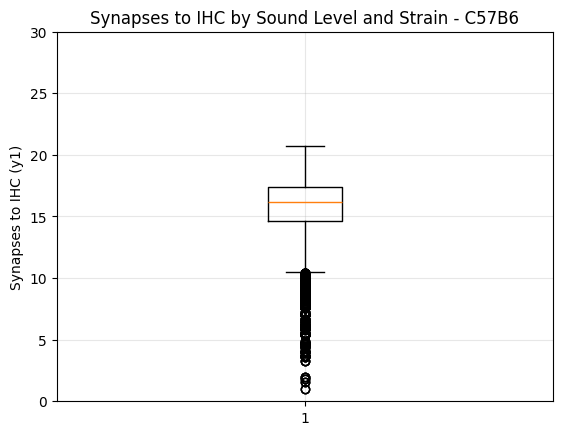

<Figure size 1000x600 with 0 Axes>

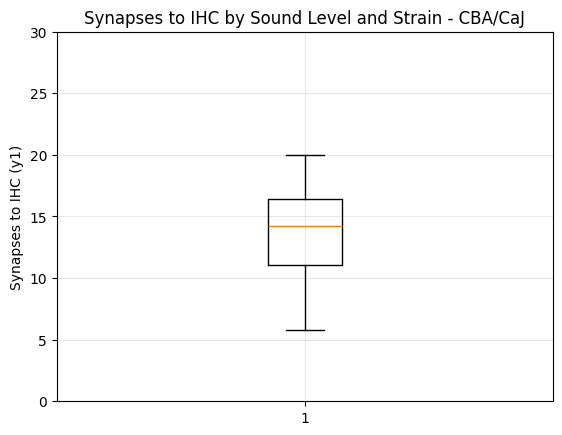

<Figure size 1000x600 with 0 Axes>

In [563]:
db_thres = 0
for strain in final_clean_strained_grouped_pos['Strain (x5)'].unique():
    subset = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Strain (x5)'] == strain) & (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres)]
    plt.boxplot(subset['Synapses to IHC (y1)'], label=strain)
# plt.xlabel('Level(dB) (x2)')
    plt.ylabel(f'Synapses to IHC (y1)')
    plt.title(f'Synapses to IHC by Sound Level and Strain - {strain}')
    plt.grid(True, alpha=0.3)
    plt.ylim((0, 30))
    plt.figure(figsize=(10, 6))
    plt.show()

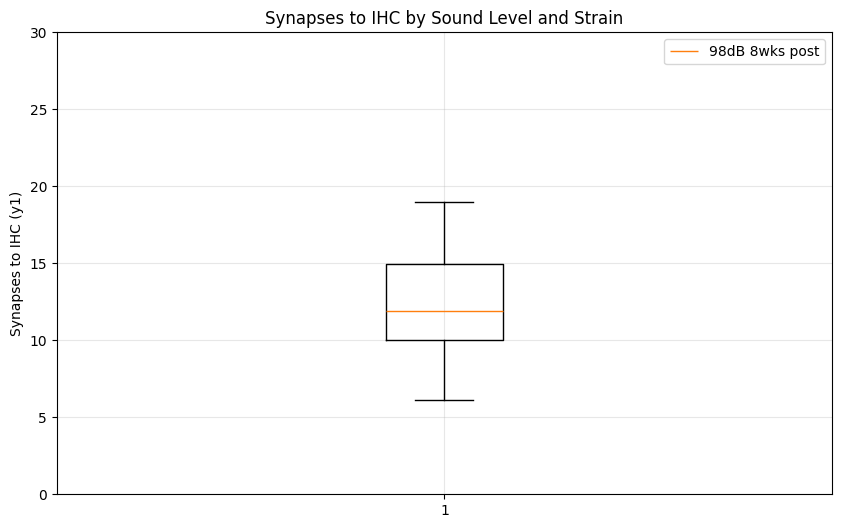

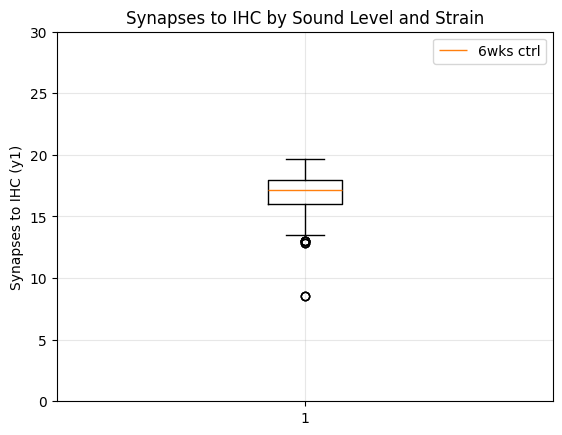

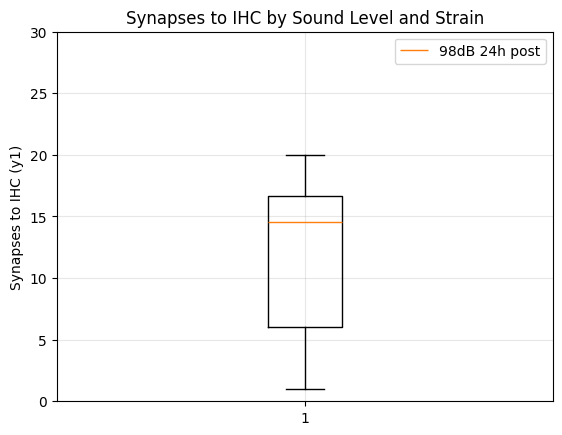

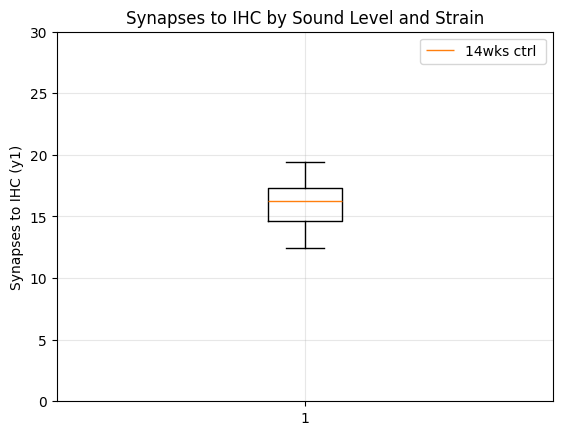

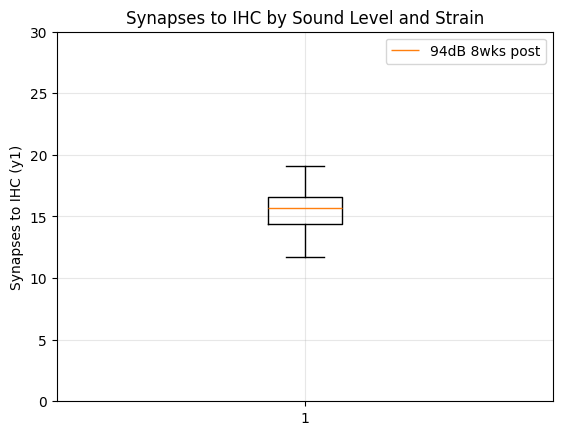

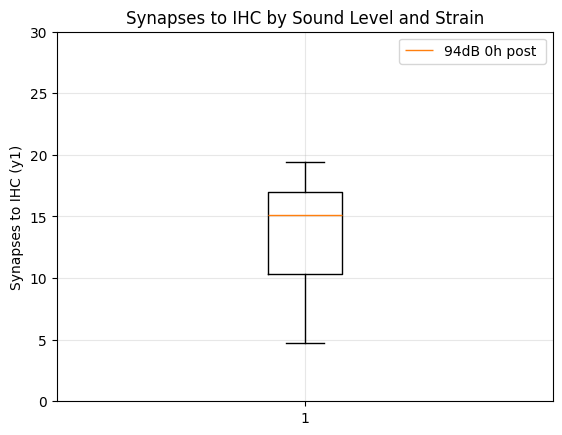

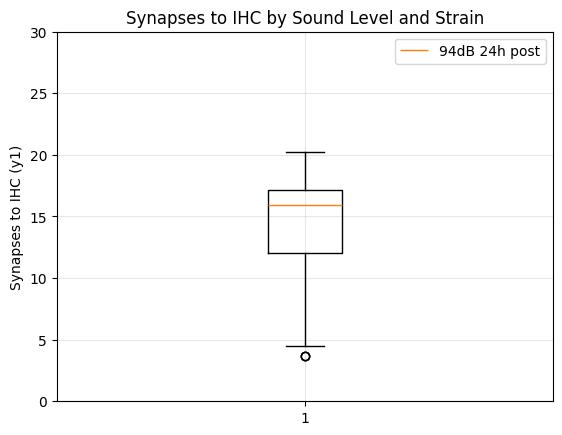

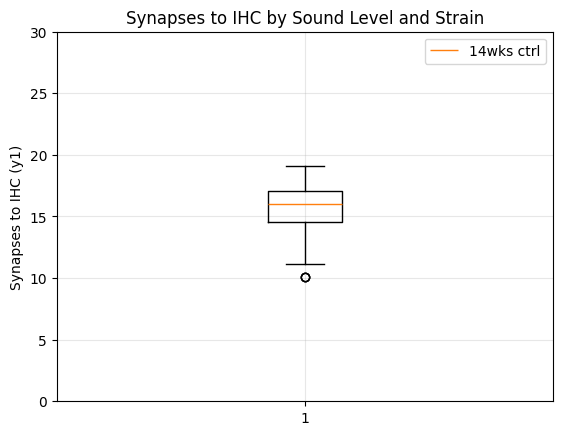

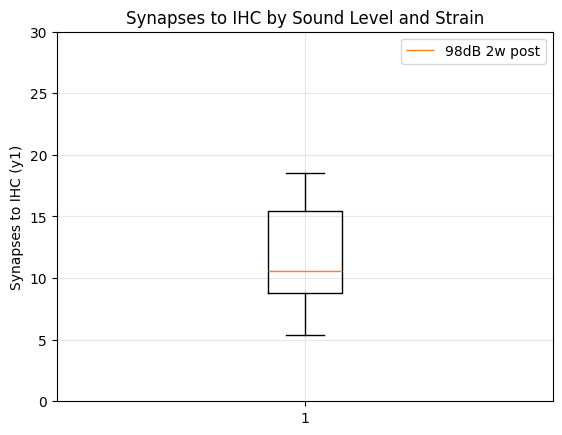

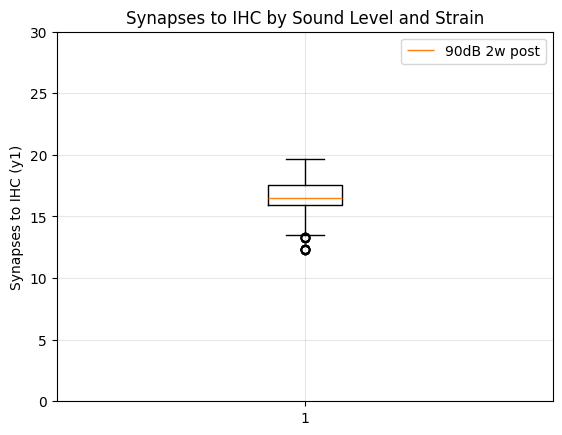

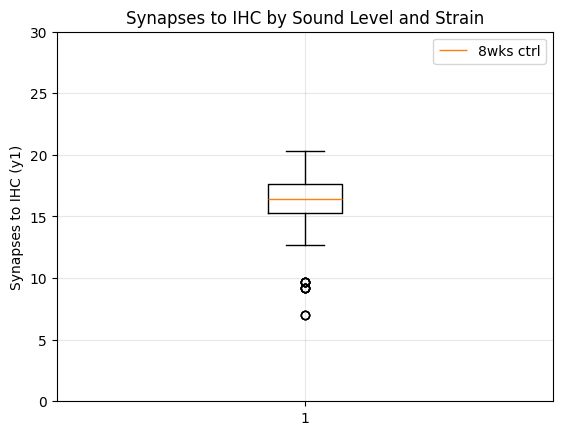

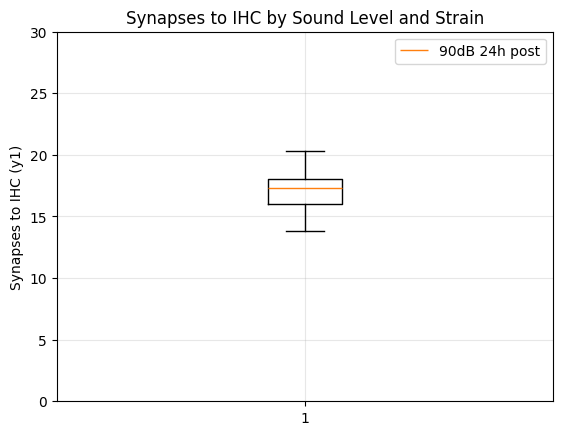

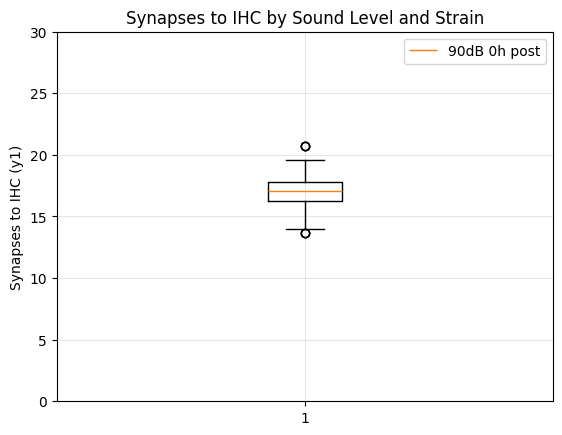

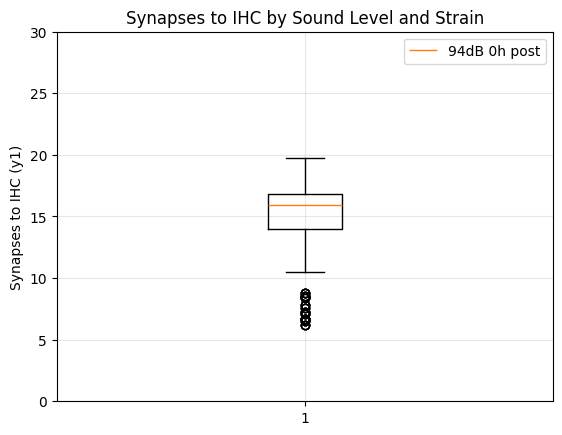

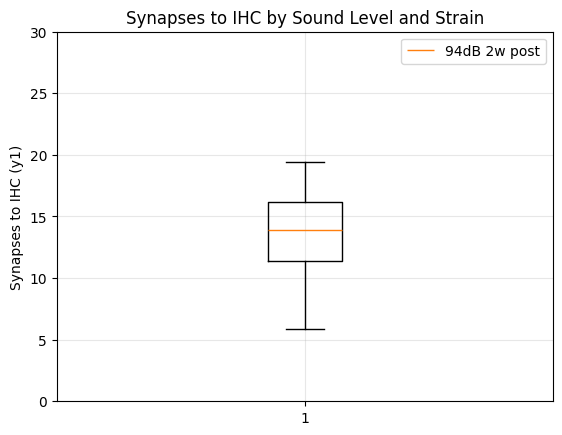

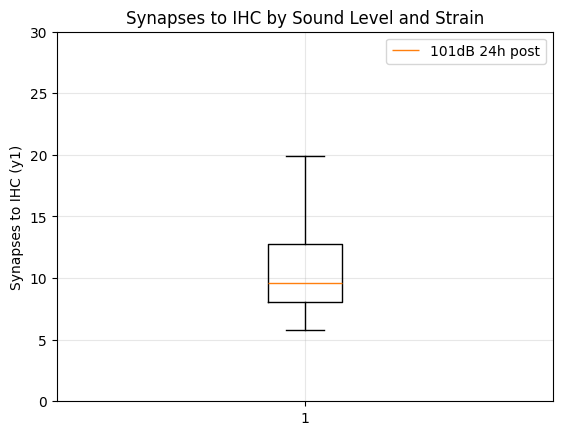

In [481]:
db_thres = 60
plt.figure(figsize=(10, 6))
for group in final_clean_strained_grouped_pos['Group'].unique():
    subset = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Group'] == group) & (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres)]
    plt.boxplot(subset['Synapses to IHC (y1)'], label=group)
# plt.xlabel('Level(dB) (x2)')
    plt.ylabel('Synapses to IHC (y1)')
    plt.title('Synapses to IHC by Sound Level and Strain')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim((0, 30))
    plt.show()

In [482]:
# db_thres = 60
# frequencies = final_clean_strained_grouped_pos['Freq(Hz) (x1)'].unique()

# # Create a separate plot for each frequency
# for freq in frequencies:
#     plt.figure(figsize=(10, 6))
    
#     # Get unique groups
#     groups = final_clean_strained_grouped_pos['Group'].unique()
    
#     # Prepare data for boxplot
#     boxplot_data = []
#     group_labels = []
    
#     for group in groups:
#         subset = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Group'] == group) & 
#                                                  (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
#                                                  (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq)]
#         # Only add non-empty groups
#         if not subset.empty:
#             boxplot_data.append(subset['Synapses to IHC (y1)'])
#             group_labels.append(group)
    
#     # Calculate overall mean for this frequency
#     overall_mean = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
#                                                   (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq)]['Synapses to IHC (y1)'].mean()
    

#     overall_med = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
#                                                   (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq)]['Synapses to IHC (y1)'].median()
    
#     # Create boxplot (only if we have data)
#     if boxplot_data:
#         bp = plt.boxplot(boxplot_data, patch_artist=True, labels=group_labels)
        
#         # Color the boxes based on groups
#         colors = ['lightblue', 'lightgreen', 'pink', 'lightyellow', 'lightcyan'][:len(boxplot_data)]
#         for patch, color in zip(bp['boxes'], colors):
#             patch.set_facecolor(color)
        
#         # Add horizontal line for overall mean
#         plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
#         plt.axhline(y=overall_med, color='purple', linestyle='--', label=f'Overall Median: {overall_med:.2f}')

#         plt.ylabel('Synapses to IHC (y1)')
#         plt.title(f'Synapses to IHC by Group at {freq} Hz (Sound Level ≥ {db_thres} dB)')
#         plt.grid(True, alpha=0.3)
#         plt.ylim((0, 30))
#         plt.xticks(rotation=45)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()
#     else:
#         print(f"No data found for any group at {freq} Hz with Level(dB) (x2) >= {db_thres}")

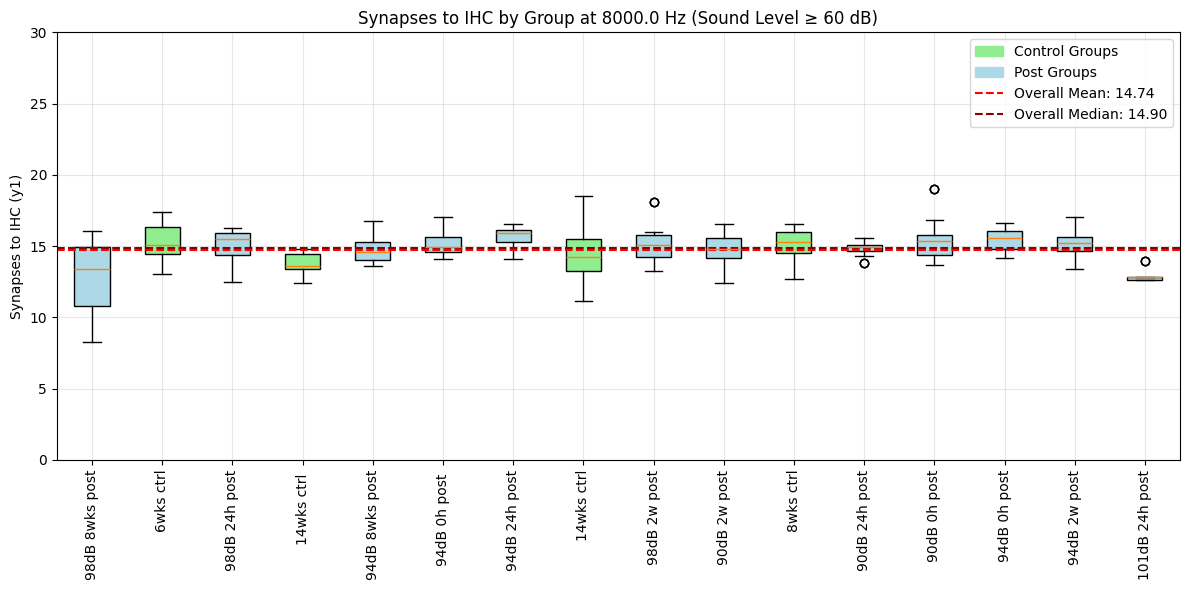

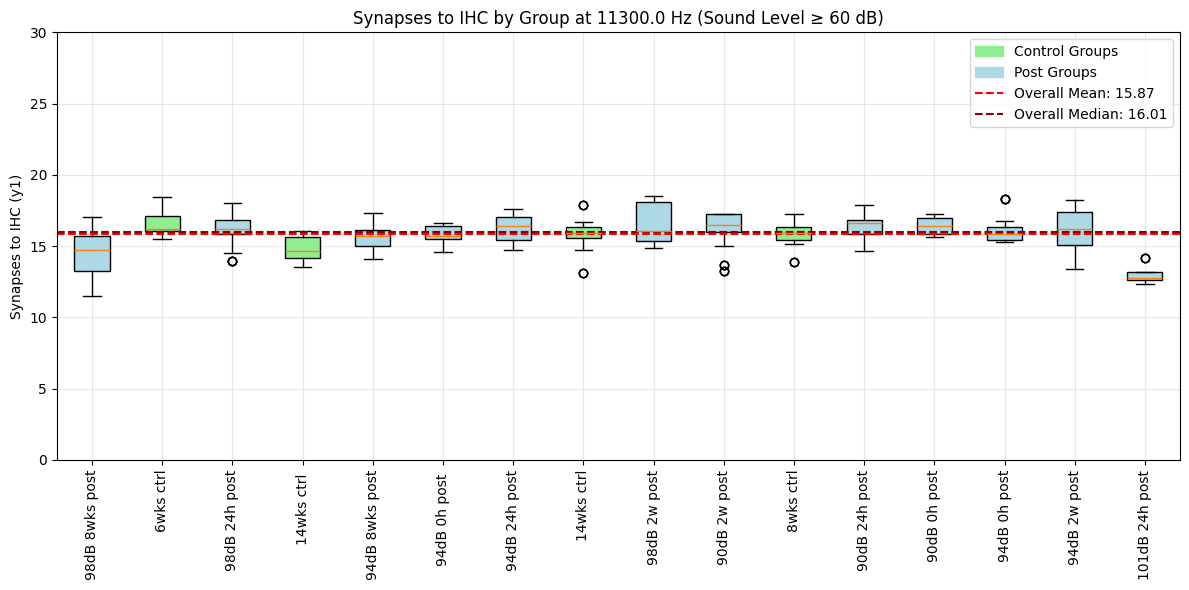

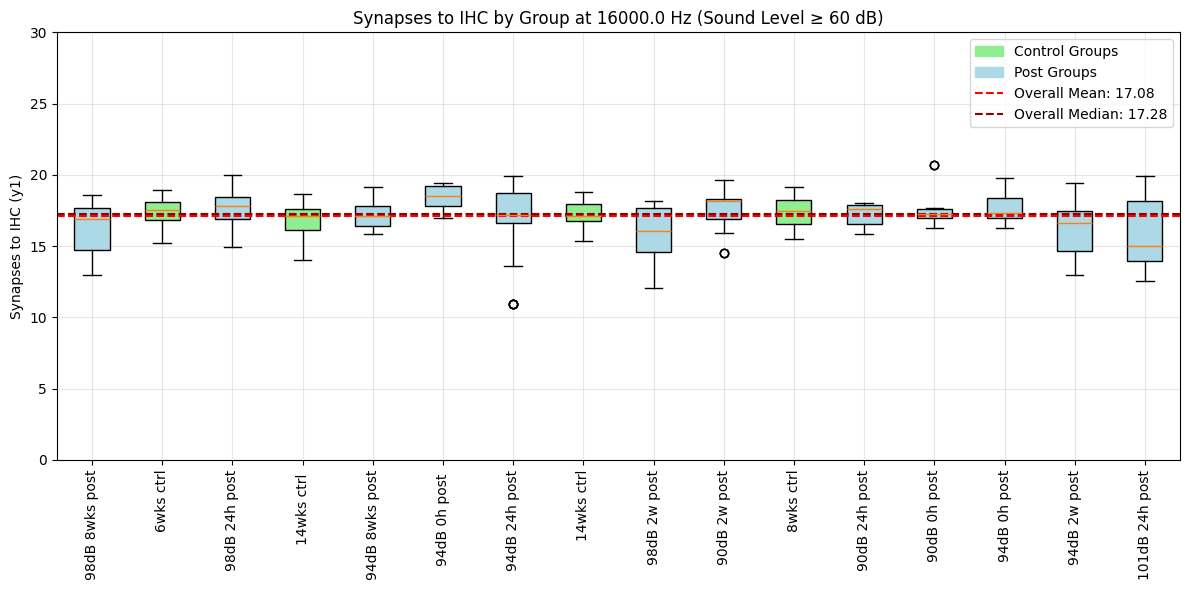

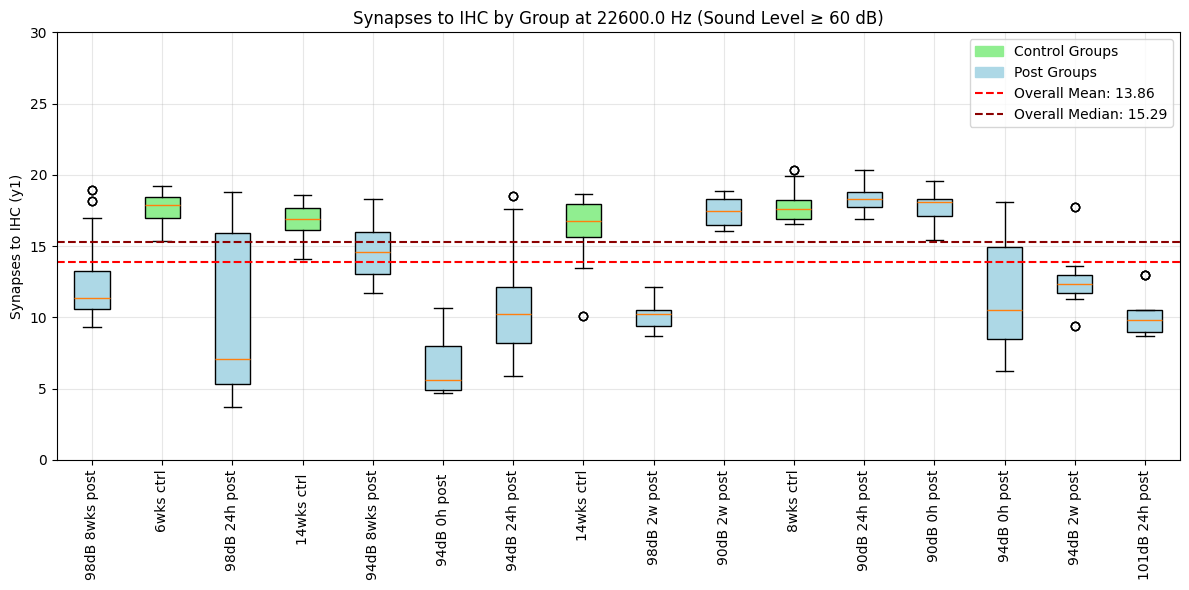

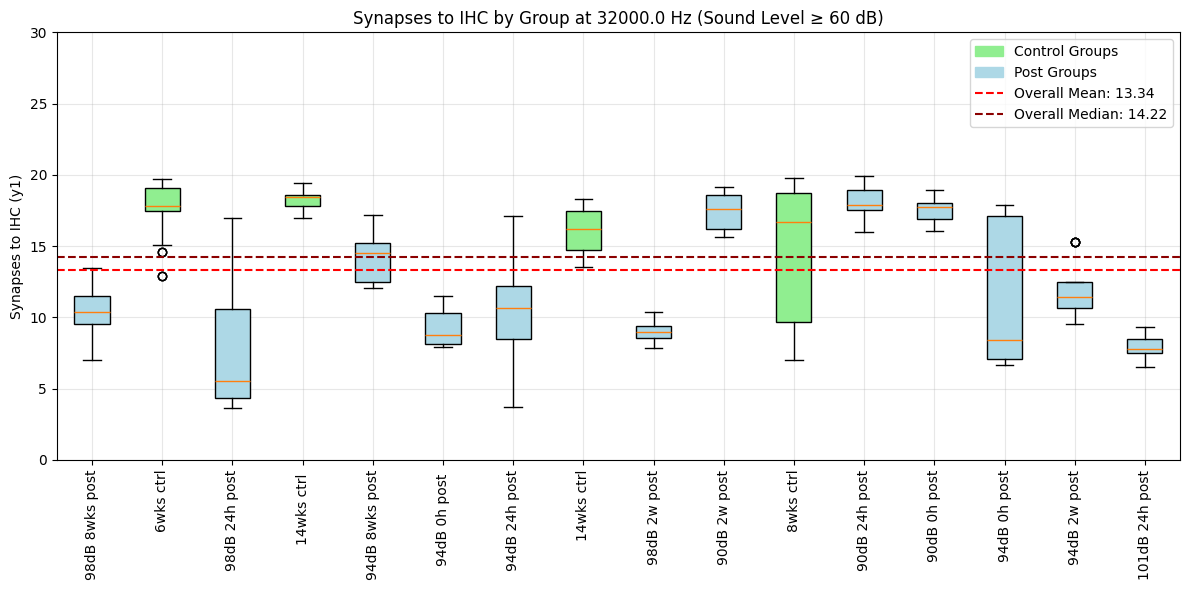

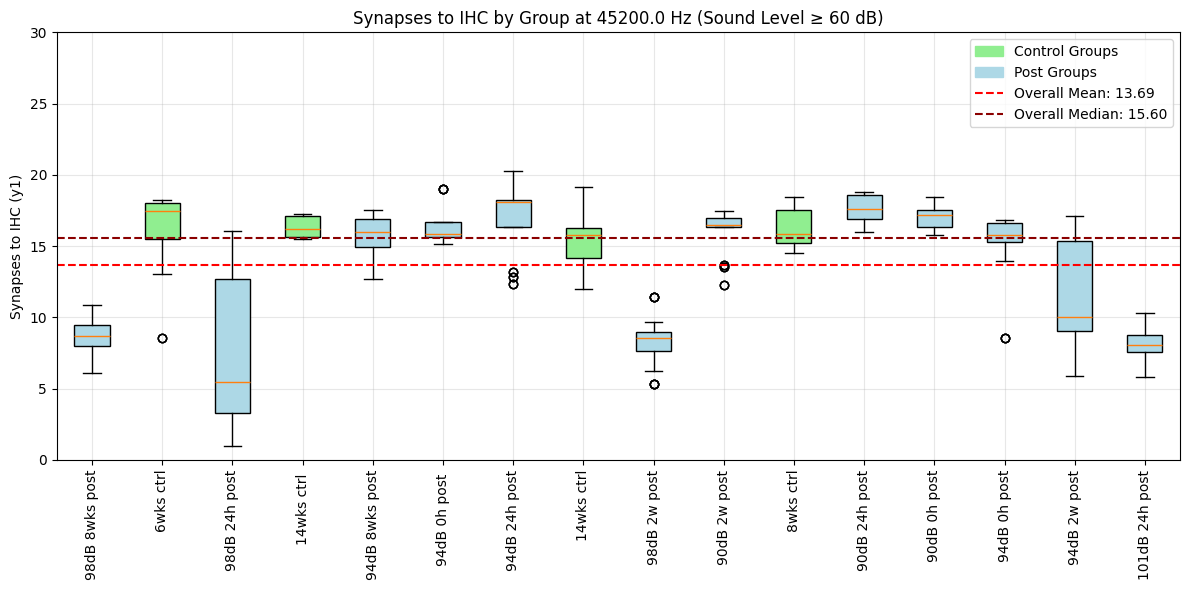

In [549]:
final_clean_strained_grouped_posdb_thres = 60
frequencies = final_clean_strained_grouped_pos['Freq(Hz) (x1)'].unique()
frequncies = frequencies.sort()

# Create a separate plot for each frequency
for freq in frequencies:
    plt.figure(figsize=(12, 6))
    
    # Get unique groups
    groups = final_clean_strained_grouped_pos['Group'].unique()
    
    # Prepare data for boxplot
    boxplot_data = []
    group_labels = []
    is_control = []  # Track which groups are controls
    
    for group in groups:
        subset = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Group'] == group) & 
                                                 (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
                                                 (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq)]
        # Only add non-empty groups
        if not subset.empty:
            boxplot_data.append(subset['Synapses to IHC (y1)'])
            group_labels.append(group)
            # Determine if this is a control group (contains 'ctrl' in the name)
            is_control.append('ctrl' in str(group).lower())
    
    # Get frequency-specific data for statistics
    freq_data = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
                                              (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq)]
    
    # Calculate statistics
    overall_mean = freq_data['Synapses to IHC (y1)'].mean()
    overall_median = freq_data['Synapses to IHC (y1)'].median()
    
    # Create boxplot (only if we have data)
    if boxplot_data:
        bp = plt.boxplot(boxplot_data, patch_artist=True, labels=group_labels)
        
        # Set colors based on whether it's a control group
        for i, (patch, is_ctrl) in enumerate(zip(bp['boxes'], is_control)):
            if is_ctrl:
                patch.set_facecolor('lightgreen')  # Color for control groups
            else:
                patch.set_facecolor('lightblue')   # Color for post groups
        
        # Create legend patches
        import matplotlib.patches as mpatches
        ctrl_patch = mpatches.Patch(color='lightgreen', label='Control Groups')
        post_patch = mpatches.Patch(color='lightblue', label='Post Groups')
        
        # Add horizontal lines for mean and median
        mean_line = plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
        median_line = plt.axhline(y=overall_median, color='darkred', linestyle='--', label=f'Overall Median: {overall_median:.2f}')

        plt.ylabel('Synapses to IHC (y1)')
        plt.title(f'Synapses to IHC by Group at {freq} Hz (Sound Level ≥ {db_thres} dB)')
        plt.grid(True, alpha=0.3)
        plt.ylim((0, 30))
        plt.xticks(rotation=90)  # Rotate labels for better readability
        
        # Add legend with control/post patches plus mean/median lines
        plt.legend(handles=[ctrl_patch, post_patch, mean_line, median_line], 
                   loc='upper right')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for any group at {freq} Hz with Level(dB) (x2) >= {db_thres}")

In [534]:
v1s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v1']
v2s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v2']

# Create a multi-index on all common factors except vx
index_cols = ['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)', 'Group']

# Reset index to make sure we're working with clean indices
v1s_indexed = v1s.reset_index().set_index(index_cols)
v2s_indexed = v2s.reset_index().set_index(index_cols)

# Now the subtraction will align properly
diff = pd.DataFrame(v1s_indexed['Synapses to IHC (y1)'] - v2s_indexed['Synapses to IHC (y1)'])

# Reset the index to get a regular DataFrame with columns
diff_reset = diff.reset_index()
diff_reset['Synapses to IHC DIFF'] = diff_reset['Synapses to IHC (y1)']
diff_reset = diff_reset.drop('Synapses to IHC (y1)', axis = 1)
# Now plot using appropriate columns
diff_reset[(diff_reset['Subject'] == 'WPZ100') & (diff_reset['Freq(Hz) (x1)'] == 16000.0)]

Subject  Freq(Hz) (x1)  Level(dB) (x2)  Amplitude (x3) Strain (x5)  \
20  WPZ100        16000.0            10.0        0.080812       C57B6   
21  WPZ100        16000.0            15.0        0.084962       C57B6   
22  WPZ100        16000.0            20.0        0.093610       C57B6   
23  WPZ100        16000.0            25.0        0.139766       C57B6   
24  WPZ100        16000.0            30.0        0.257040       C57B6   
25  WPZ100        16000.0            35.0        0.426837       C57B6   
26  WPZ100        16000.0            40.0        0.422973       C57B6   
27  WPZ100        16000.0            50.0        0.618429       C57B6   
28  WPZ100        16000.0            60.0        0.884023       C57B6   
29  WPZ100        16000.0            70.0        1.286912       C57B6   
30  WPZ100        16000.0            80.0        1.583169       C57B6   

        Group  Synapses to IHC DIFF  
20  8wks ctrl             -1.794872  
21  8wks ctrl             -1.794872  
22  8wks ctrl             -1.794872  
23  8wks ctrl             -1.794872  
24  8wks ctrl             -1.794872  
25  8wks ctrl             -1.794872  
26  8wks ctrl             -1.794872  
27  8wks ctrl             -1.794872  
28  8wks ctrl             -1.794872  
29  8wks ctrl             -1.794872  
30  8wks ctrl             -1.794872

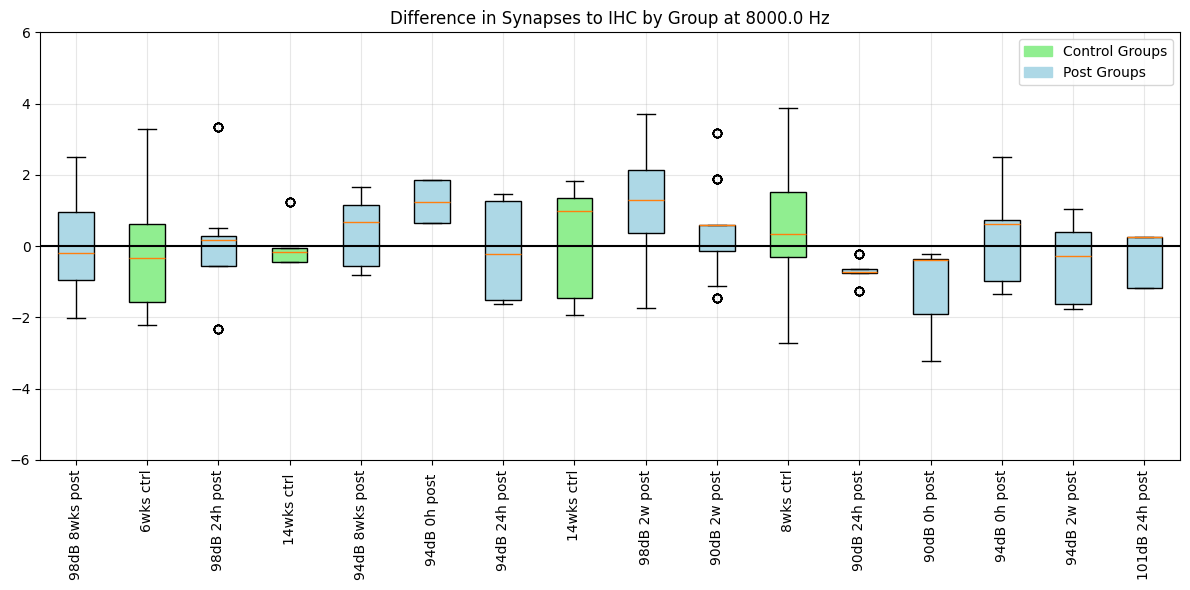

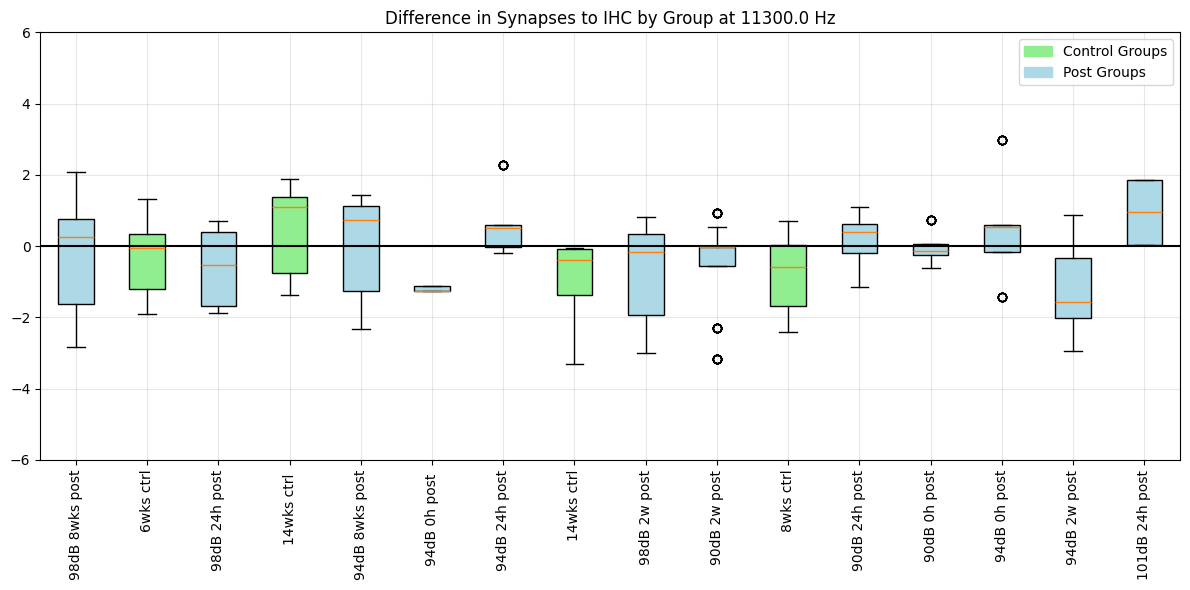

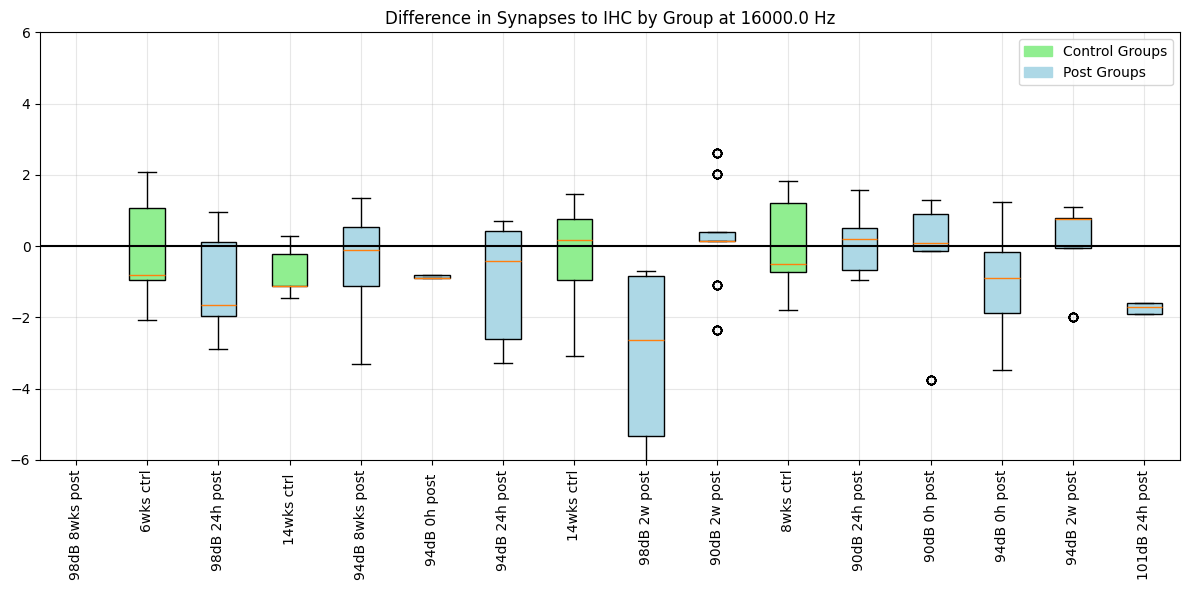

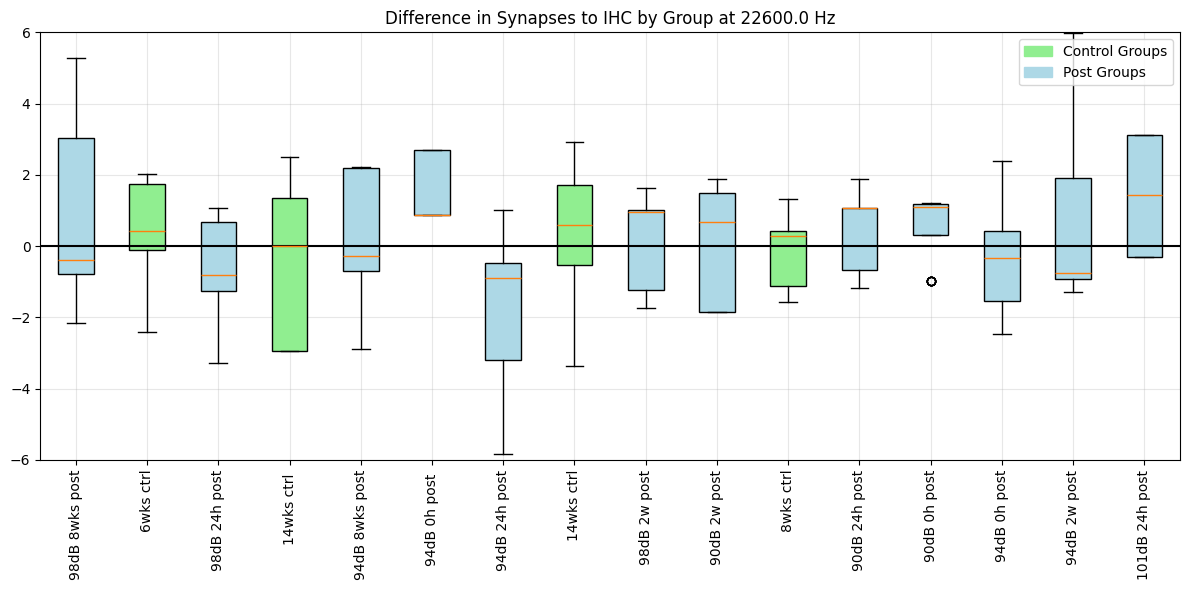

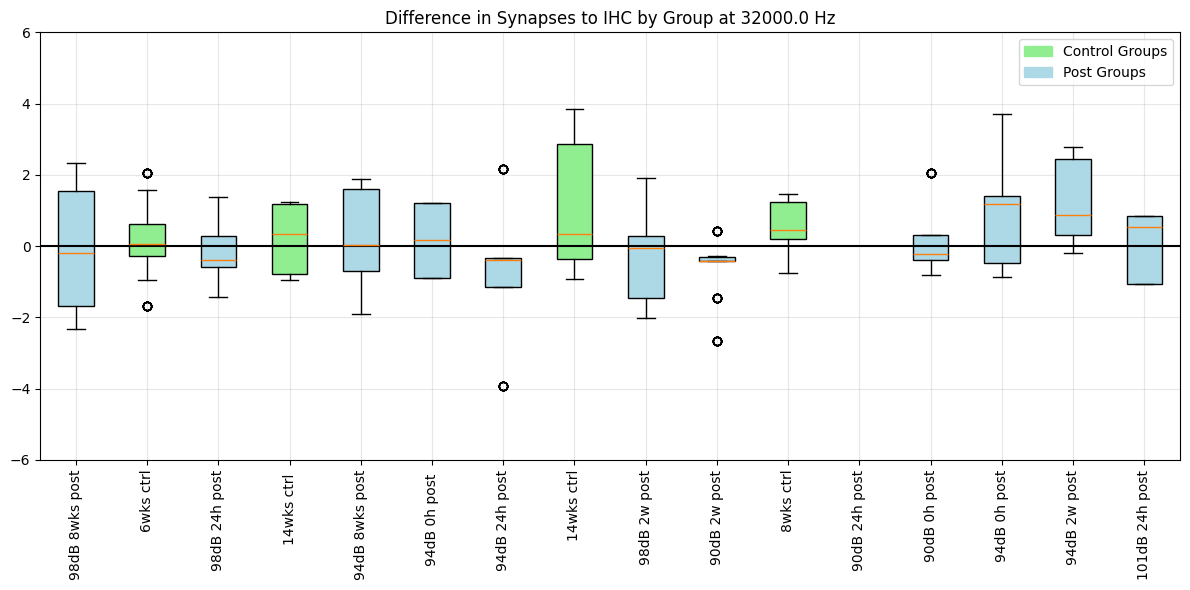

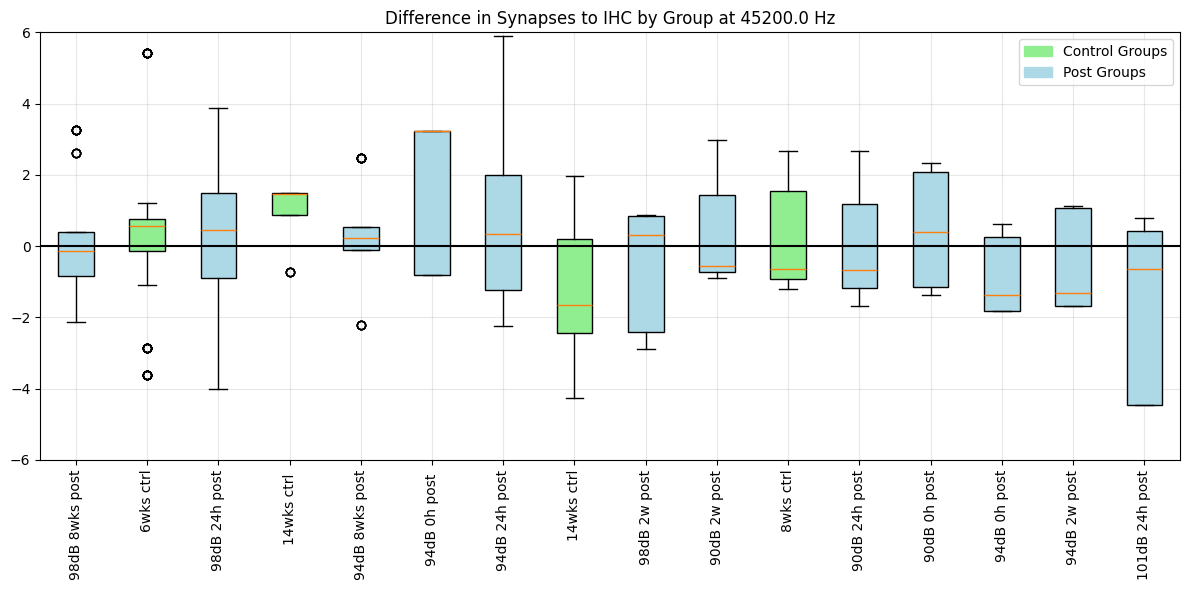

In [550]:
# final_clean_strained_grouped_posdb_thres = 60
frequencies = final_clean_strained_grouped_pos['Freq(Hz) (x1)'].unique()
frequncies = frequencies.sort()

# Create a separate plot for each frequency
for freq in frequencies:
    plt.figure(figsize=(12, 6))
    
    # Get unique groups
    groups = final_clean_strained_grouped_pos['Group'].unique()
    
    # Prepare data for boxplot
    boxplot_data = []
    group_labels = []
    is_control = []  # Track which groups are controls
    
    for group in groups:
        subset = diff_reset[(diff_reset['Group'] == group) & 
                                                #  (diff_reset['Level(dB) (x2)'] >= db_thres) &
                                                 (diff_reset['Freq(Hz) (x1)'] == freq)]
        # Only add non-empty groups
        if not subset.empty:
            boxplot_data.append(subset['Synapses to IHC DIFF'])
            group_labels.append(group)
            # Determine if this is a control group (contains 'ctrl' in the name)
            is_control.append('ctrl' in str(group).lower())
    
    # Get frequency-specific data for statistics
    freq_data = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq] # (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
    
    # Calculate statistics
    overall_mean = freq_data['Synapses to IHC (y1)'].mean()
    overall_median = freq_data['Synapses to IHC (y1)'].median()


# import matplotlib.patches as mpatches
    # Create boxplot (only if we have data)
    if boxplot_data:
        bp = plt.boxplot(boxplot_data, patch_artist=True, labels=group_labels)

        for i, (patch, is_ctrl) in enumerate(zip(bp['boxes'], is_control)):
            if is_ctrl:
                patch.set_facecolor('lightgreen')  # Color for control groups
            else:
                patch.set_facecolor('lightblue')   # Color for post groups
        
        # Create legend patches
        import matplotlib.patches as mpatches
        ctrl_patch = mpatches.Patch(color='lightgreen', label='Control Groups')
        post_patch = mpatches.Patch(color='lightblue', label='Post Groups')

        plt.title(f'Difference in Synapses to IHC by Group at {freq} Hz')
        plt.grid(True, alpha=0.3)
        plt.ylim((-6, 6))
        plt.xticks(rotation=90)  # Rotate labels for better readability
        
        # Add legend with control/post patches plus mean/median lines
        plt.legend(handles=[ctrl_patch, post_patch], 
                   loc='upper right')
        plt.axhline(y=0, color='black', linestyle='-')
        plt.tight_layout()
        plt.show()

In [546]:
final_clean_strained_grouped_pos['Group'].value_counts(normalize=True, ascending=False)

Group
6wks ctrl         0.140660
98dB 8wks post    0.097804
14wks ctrl        0.088673
90dB 2w post      0.086864
8wks ctrl         0.085054
94dB 2w post      0.061857
98dB 2w post      0.058238
94dB 8wks post    0.057086
98dB 24h post     0.053138
90dB 0h post      0.053138
94dB 24h post     0.052316
90dB 24h post     0.050177
94dB 0h post      0.044912
14wks ctrl        0.037838
101dB 24h post    0.019906
94dB 0h post      0.012339
Name: proportion, dtype: float64

# Random Forest

## **First runs, no CV. IGNORE**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score

Without vx or normalization

In [15]:
X_num = final_clean[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
# X_cat = final_clean['vx (x4)']
# X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
# X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']
# y2 = final_clean['IHCs (y2)']

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), X_num.columns),  # Standardize numerical features
])

# Create Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X_num, y1, test_size=0.2, random_state=42)

# Train the model
rf_pipeline.fit(X_train, y1_train)

# Extract trained Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

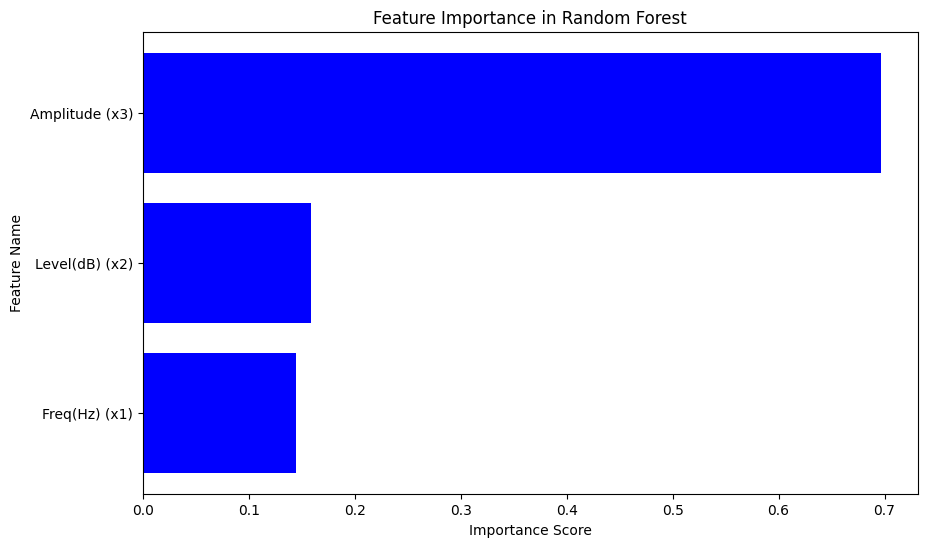

In [16]:
# Get feature names after preprocessing
feature_names = X_num.columns.tolist()
# cat_features = ['v2']  # Because OneHotEncoder(drop='first') removes 'V1', only 'V2' remains

# feature_names = num_features

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [17]:
y1_pred = rf_model.predict(X_test)
results = pd.DataFrame(data={'Predicted y1': y1_pred, 'Actual y1': y1_test})

RMSE = np.sqrt(np.mean((results['Actual y1'] - results['Predicted y1'])**2))
RMSE

np.float64(3.580749589100933)

After strain

With vx and without normalization

In [358]:
from sklearn.model_selection import train_test_split

X_num = final_clean[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']
# y2 = final_clean['IHCs (y2)']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
    ])

# Create full pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

# Split into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42)

# Train the model
rf_pipeline.fit(X_train, y1_train)

# Extract trained Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

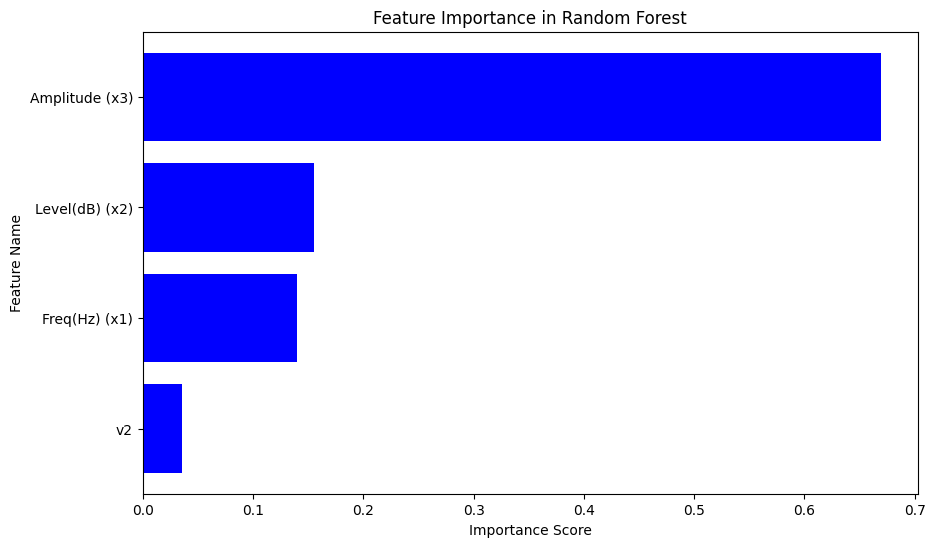

In [359]:
# Get feature names after preprocessing
num_features = X_num.columns.tolist()
cat_features = ['v2']  # Because OneHotEncoder(drop='first') removes 'V1', only 'V2' remains

feature_names = num_features + cat_features

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [360]:
y1_pred = rf_model.predict(X_test)
results = pd.DataFrame(data={'Predicted y1': y1_pred, 'Actual y1': y1_test})

RMSE = np.sqrt(np.mean((results['Actual y1'] - results['Predicted y1'])**2))
RMSE

np.float64(2.2241490517480376)

Per Group

Without vx and with normalization

In [21]:
X_num = final_clean[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
# X_cat = final_clean['vx (x4)']
# X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
# X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)'])
    ])

# Create full pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

# Split into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X_num, y1, test_size=0.2, random_state=42)

# Train the model
rf_pipeline.fit(X_train, y1_train)

# Extract trained Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

In [22]:
y1_pred = rf_model.predict(X_test)
results = pd.DataFrame(data={'Predicted y1': y1_pred, 'Actual y1': y1_test})

RMSE = np.sqrt(np.mean((results['Actual y1'] - results['Predicted y1'])**2))
RMSE

np.float64(4.172023923348762)

In [23]:
y1_pred = rf_model.predict(X_test)
results = pd.DataFrame(data={'Predicted y1': y1_pred, 'Actual y1': y1_test})

RMSE = np.sqrt(np.mean((results['Actual y1'] - results['Predicted y1'])**2))
RMSE

np.float64(4.172023923348762)

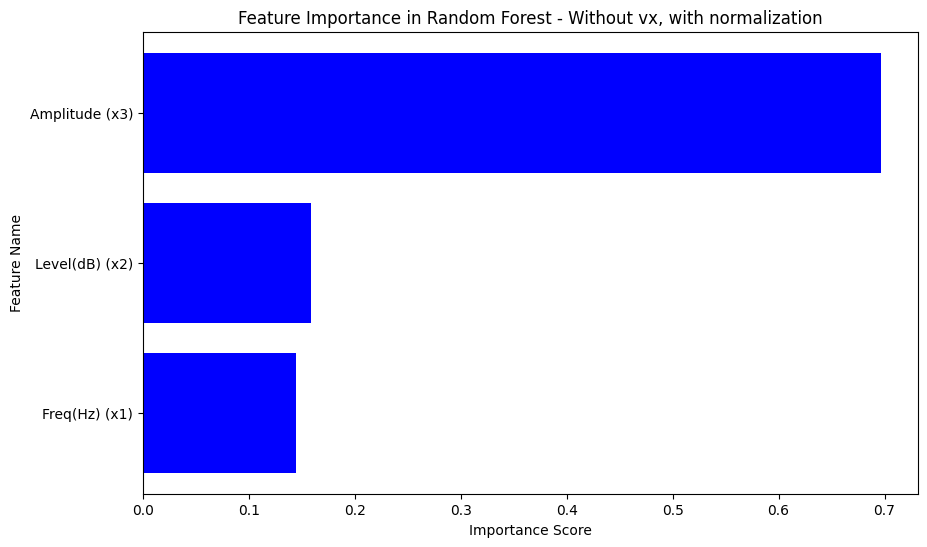

In [24]:
# Get feature names after preprocessing
num_features = X_num.columns.tolist()
cat_features = ['v2']  # Because OneHotEncoder(drop='first') removes 'V1', only 'V2' remains

feature_names = num_features # + cat_features

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest - Without vx, with normalization')
plt.gca().invert_yaxis()
plt.show()

With vx and normalization

In [25]:
X_num = final_clean[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
    ])

# Create full pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

# Split into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42)

# Train the model
rf_pipeline.fit(X_train, y1_train)

# Extract trained Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

In [26]:
y1_pred = rf_model.predict(X_test)
results = pd.DataFrame(data={'Predicted y1': y1_pred, 'Actual y1': y1_test})

RMSE = np.sqrt(np.mean((results['Actual y1'] - results['Predicted y1'])**2))
RMSE

np.float64(4.13521969377782)

In [27]:
X_num = final_clean[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
    ])

# Create full pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

# Split into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42)

# Train the model
rf_pipeline.fit(X_train, y1_train)

# Extract trained Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

In [28]:
y1_pred = rf_model.predict(X_test)
results = pd.DataFrame(data={'Predicted y1': y1_pred, 'Actual y1': y1_test})

RMSE = np.sqrt(np.mean((results['Actual y1'] - results['Predicted y1'])**2))
RMSE

np.float64(3.5151203382912577)

## **Cross-Validation**

## Without vx or normalization

In [429]:
X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
y1 = final_clean_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', 'passthrough', X_num.columns),  # Standardize numerical features
])

X_train, X_test, y1_train, y1_test = train_test_split(X_num, y1, test_size=0.2, random_state=42)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [430]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

final_pipeline.fit(X_train, y1_train)
final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')

Train set RMSE: 2.3513

Final Test Set RMSE: 2.1489


## With vx, without normalization

In [262]:
X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_70['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)
y1 = final_clean_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', 'passthrough', X_num.columns),  # Standardize numerical features
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
])

X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [428]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
final_pipeline.fit(X_train, y1_train)

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')

Train set RMSE: 2.3513

Final Test Set RMSE: 2.1489


PER GROUP

## Without vx and with normalization

In [264]:
X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
y1 = final_clean_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), X_num.columns),  # Standardize numerical features
])

X_train, X_test, y1_train, y1_test = train_test_split(X_num, y1, test_size=0.2, random_state=42)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [265]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
final_pipeline.fit(X_train, y1_train)
final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')


Final Test Set RMSE: 2.1483


In [266]:
X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
y1 = final_clean_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', MinMaxScaler(), X_num.columns),  # Standardize numerical features
])

X_train, X_test, y1_train, y1_test = train_test_split(X_num, y1, test_size=0.2, random_state=42)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [267]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
final_pipeline.fit(X_train, y1_train)
final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')


Final Test Set RMSE: 2.1493


## With vx, normalization

In [269]:
X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_70['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)
y1 = final_clean_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), X_num.columns),  # Standardize numerical features
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
])

X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [270]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
final_pipeline.fit(X_train, y1_train)
final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')


Final Test Set RMSE: 2.4018


In [271]:
X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_70['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)
y1 = final_clean_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', MinMaxScaler(), X_num.columns),  # Standardize numerical features
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
])

X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [272]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
final_pipeline.fit(X_train, y1_train)
final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')


Final Test Set RMSE: 2.4016


## With strain, with normalization

In [274]:
X_num = final_clean_strained_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_strained_70['Strain (x5)']
X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)
y1 = final_clean_strained_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), X_num.columns),  # Standardize numerical features
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
])

X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [275]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
final_pipeline.fit(X_train, y1_train)
final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')


Final Test Set RMSE: 2.0931


In [ ]:
X_num = final_clean_strained_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_strained_70['Strain (x5)']
X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean_strained_70['Synapses to IHC (y1)']

preprocessor = ColumnTransformer([
    ('num_scaler', MinMaxScaler(), X_num.columns),  # Standardize numerical features
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
])

X_train, X_test, y1_train, y1_test = train_test_split(X_combined, y1, test_size=0.2, random_state=42, stratify=)

k_folds = KFold(n_splits = 5)
cv_scores = []
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train)):
    # Split the training data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train.iloc[train_idx], y1_train.iloc[val_idx]

    # Create Random Forest Pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
        max_depth=10,  # Limit tree depth
        min_samples_leaf=5))
    ])

    # Train the model
    rf_pipeline.fit(X_train, y1_train)

    # Extract trained Random Forest model from the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    y_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(np.mean((y_fold_val - y_pred)**2))
    rmse_scores.append(rmse)

In [363]:
# mean_rmse = np.mean(rmse_scores)
# std_rmse = np.std(rmse_scores)
# print(f'\nMean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})')

# Finally, you can evaluate on the test set using your best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
final_pipeline.fit(X_train, y1_train)
final_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(np.mean((y1_test - final_pred)**2))
print(f'\nFinal Test Set RMSE: {final_rmse:.4f}')


Final Test Set RMSE: 2.0912


# Neural Networks

## Training / Val Functions

In [189]:
# Setting up linear and loss functions

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
# def mse_loss(a,b, x, y): return mse(lin(a,b,x), y) # TO BE UPDATED once lin is fixed for new set-up

def val_metric(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3, x4_encoded = torch.split(x, [1,1,1,1], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3,x4_encoded)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3, x4_encoded)

            loss = torch.sqrt(F.mse_loss(y_hat, y))
            # loss = mse(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)

In [190]:
def train_loop(model, train_dl, valid_dl, optimizer, epochs):
    train_losses, valid_losses, valid_r2s = [], [], []
    
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        
        # Training loop
        for batch in train_dl:
            x, y = batch
            y = y.unsqueeze(1)
            x1,x2,x3,x4_encoded = torch.split(x, [1,1,1,1], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3,x4_encoded)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = torch.sqrt(F.mse_loss(y_hat, y) + 1e-8)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After all batches in epoch, compute averages
        epoch_train_loss = np.mean(batch_losses)
        epoch_valid_loss, epoch_valid_r2 = val_metric(model, valid_dl)
        
        # Store epoch metrics
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        valid_r2s.append(epoch_valid_r2)
        
        # print(f"Epoch {i+1}: train loss {epoch_train_loss:.3f} valid loss {epoch_valid_loss:.3f} R^2 {epoch_valid_r2:.3f}")

    # Calculate final averages using numpy
    avg_train_loss = np.mean(train_losses)
    avg_valid_loss = np.mean(valid_losses)
    avg_valid_r2 = np.mean(valid_r2s)
    
    return avg_train_loss, avg_valid_loss, avg_valid_r2

## Fine tuning the hidden size (testing different levels of complexity)

In [ ]:
# hidden_sizes = [5, 8, 16, 32]
# batches = [16,32,64]
# learning_rate = 0.01

# all_batch_sizes = []
# all_hidden_sizes = []
# all_train_losses = []
# all_val_losses = []
# all_val_R2s = []

# for size in hidden_sizes:
#     for batch in batches:
#         model1 = Ratio_LRNN_v2(hidden_layer=size)
#         optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
#         torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

#         train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
#         train_dl = DataLoader(train_dataset1, batch_size=batch, shuffle=True)

#         valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
#         valid_dl = DataLoader(valid_dataset1, batch_size=batch, shuffle=False)
#         # print(f"Model with hidden layer = {size}")
#         train_loss, valid_loss, valid_r2 = train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=10)
#         all_batch_sizes.append(batch)
#         all_hidden_sizes.append(size)
#         all_train_losses.append(train_loss)
#         all_val_losses.append(valid_loss)
#         all_val_R2s.append(valid_r2)

# results = pd.DataFrame(data={'Batch Size': all_batch_sizes, 'Hidden Size': all_hidden_sizes, 'Train losses' : all_train_losses, 'Val losses' : all_val_losses, 'Val R2s': all_val_R2s})

NameError: name 'Ratio_LRNN_v2' is not defined

In [ ]:
results

Batch Size  Hidden Size  Train losses  Val losses   Val R2s
0           16            5     10.670662    7.634632  0.176643
1           32            5     12.928269    7.324814  0.209978
2           64            5     17.846079   10.689269 -0.163135
3           16            8     10.222640    7.510617  0.189658
4           32            8     12.200218    7.468637  0.193463
5           64            8     16.624144    7.119184  0.230849
6           16           16      9.756241    7.717890  0.167097
7           32           16     10.615163    7.148387  0.228900
8           64           16     13.783908    7.092517  0.233472
9           16           32      9.277223    7.419671  0.199599
10          32           32     10.071053    7.193591  0.223311
11          64           32     12.233400    7.001095  0.243873

## 2-way Interaction Terms and vx

In [197]:
# two-way

class Ratio_LRNN_v3(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v3, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 8 # x1, x2, x3, x4 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded, x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x4, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x4, torch.Tensor):
            x4 = torch.tensor(x4.values if hasattr(x4, 'values') else x4)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x4 = x4.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x4)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

## Testing Feature Importance

In [198]:
# Setting up data

torch.manual_seed(42)
np.random.seed(42)

X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]

X_cat = final_clean_70['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean_70['Synapses to IHC (y1)']

X_train, X_test, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y1_train = y1_train.astype('float64')
y1_test = y1_test.astype('float64')

X_train_tensor1 = torch.FloatTensor(X_train.values)
X_test_tensor1 = torch.FloatTensor(X_test.values)
y1_train_tensor = torch.FloatTensor(y1_train.values)
y1_test_tensor = torch.FloatTensor(y1_test.values)


In [199]:
model1 = Ratio_LRNN_v3(8)

learning_rate = 0.01
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

train_loss, valid_loss, valid_r2 = train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.6688857688420056),
 np.float64(3.2672421332862642),
 np.float64(0.017188590356848166))

In [203]:
train_loss, valid_loss, valid_r2 = train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.0523187857607135),
 np.float64(2.7600139038430322),
 np.float64(0.34190486541483595))

In [151]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error

# def permutation_importance(model, X_val, y_val):
#     baseline_score = mean_squared_error(y_val, model.predict(X_val['Freq(Hz) (x1)'], X_val['Level(dB) (x2)'], X_val['Amplitude (x3)'], X_val['vx (x4)']))
#     importance_scores = {}
    
#     for feature in X_val.columns:
#         # Create shuffled copy
#         X_shuffled = X_val.copy()
#         X_shuffled[feature] = np.random.permutation(X_shuffled[feature])
        
#         # Calculate performance drop
#         shuffled_score = mean_squared_error(y_val, model.predict(X_shuffled['Freq(Hz) (x1)'], X_shuffled['Level(dB) (x2)'], X_shuffled['Amplitude (x3)'], X_shuffled['vx (x4)']))
#         importance = baseline_score - shuffled_score
#         importance_scores[feature] = importance
        
#     return importance_scores

# def visualize_importance(importance_scores):
#     features = list(importance_scores.keys())
#     scores = list(importance_scores.values())
    
#     plt.figure(figsize=(10, 6))
#     plt.barh(features, scores)
#     plt.xlabel('Importance Score')
#     plt.ylabel('Feature')
#     plt.title('Feature Importance')
#     plt.tight_layout()

In [152]:
# X_train_pi, X_val_pi, y_train_pi, y_val_pi = train_test_split(X_train, y1_train, test_size=0.2)

# importance = permutation_importance(
#     model1, 
#     X_val_pi, 
#     y_val_pi
# )
# visualize_importance(importance)

Currently, NN model isn't predicting well. Negative feature importance charts indiciate that the RMSE is actually not improving when performing permutation importance testing...

## 3-way interactions with vx

In [204]:
# two-way

class Ratio_LRNN_v3_5(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v3_5, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 8 # x1, x2, x3, x4 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude
        x1x2x3 = x1 * x2 * x3

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded, x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x4, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x4, torch.Tensor):
            x4 = torch.tensor(x4.values if hasattr(x4, 'values') else x4)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x4 = x4.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x4)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [205]:
# Setting up data

torch.manual_seed(42)
np.random.seed(42)

X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]

X_cat = final_clean_70['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean_70['Synapses to IHC (y1)']

X_train, X_test, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y1_train = y1_train.astype('float64')
y1_test = y1_test.astype('float64')

X_train_tensor1 = torch.FloatTensor(X_train.values)
X_test_tensor1 = torch.FloatTensor(X_test.values)
y1_train_tensor = torch.FloatTensor(y1_train.values)
y1_test_tensor = torch.FloatTensor(y1_test.values)


In [206]:
model1 = Ratio_LRNN_v3(8)

learning_rate = 0.01
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

train_loss, valid_loss, valid_r2 = train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.6688857688420056),
 np.float64(3.2672421332862642),
 np.float64(0.017188590356848166))

In [210]:
train_loss, valid_loss, valid_r2 = train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.0523187857607135),
 np.float64(2.7600139038430322),
 np.float64(0.34190486541483595))

## 3-way interactions without vx

In [216]:
# Setting up data

torch.manual_seed(42)
np.random.seed(42)

X_num = final_clean_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]

# X_cat = final_clean_70['vx (x4)']
# X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
# X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean_70['Synapses to IHC (y1)']

X_train, X_test, y1_train, y1_test = train_test_split(
    X_num, y1,
    test_size=0.2,
    random_state=42
)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y1_train = y1_train.astype('float64')
y1_test = y1_test.astype('float64')

X_train_tensor1 = torch.FloatTensor(X_train.values)
X_test_tensor1 = torch.FloatTensor(X_test.values)
y1_train_tensor = torch.FloatTensor(y1_train.values)
y1_test_tensor = torch.FloatTensor(y1_test.values)


In [217]:
# Update train loops for new predictors

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
# def mse_loss(a,b, x, y): return mse(lin(a,b,x), y) # TO BE UPDATED once lin is fixed for new set-up

def val_metric_v4(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3 = torch.split(x, [1,1,1], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3)

            loss = torch.sqrt(F.mse_loss(y_hat, y))
            # loss = mse(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)


def train_loop_v4(model, train_dl, valid_dl, optimizer, epochs):
    train_losses, valid_losses, valid_r2s = [], [], []
    
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        
        # Training loop
        for batch in train_dl:
            x, y = batch
            y = y.unsqueeze(1)
            x1,x2,x3 = torch.split(x, [1,1,1], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = torch.sqrt(F.mse_loss(y_hat, y) + 1e-8)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After all batches in epoch, compute averages
        epoch_train_loss = np.mean(batch_losses)
        epoch_valid_loss, epoch_valid_r2 = val_metric_v4(model, valid_dl)
        
        # Store epoch metrics
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        valid_r2s.append(epoch_valid_r2)
        
        # print(f"Epoch {i+1}: train loss {epoch_train_loss:.3f} valid loss {epoch_valid_loss:.3f} R^2 {epoch_valid_r2:.3f}")

    # Calculate final averages using numpy
    avg_train_loss = np.mean(train_losses)
    avg_valid_loss = np.mean(valid_losses)
    avg_valid_r2 = np.mean(valid_r2s)
    
    return avg_train_loss, avg_valid_loss, avg_valid_r2

In [218]:
# Best so far!!

class Ratio_LRNN_v4(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v4, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 7 # x1, x2, x3, and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            # nn.Linear(self.input_size, hidden_layer), #new
            # nn.ReLU(), #new
            # nn.Linear(self.input_size, hidden_layer), #new
            # nn.ReLU(), #new
            # nn.Linear(self.input_size, hidden_layer), #new
            # nn.ReLU(), #new
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3):
        # x4_encoded = torch.zeros(x4.size(0),2)
        # x4_encoded[x4=='v1',0] = 1
        # x4_encoded[x4=='v2',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude
        x1x2x3 = x1*x2*x3 # All

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [221]:
model1 = Ratio_LRNN_v4(hidden_layer=8)

learning_rate = 0.01
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

train_loss, valid_loss, valid_r2 = train_loop_v4(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.3371179578528887),
 np.float64(2.882471529891094),
 np.float64(0.2758928648231755))

In [223]:
train_loss, valid_loss, valid_r2 = train_loop_v4(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.0425552659708517),
 np.float64(2.759640250686142),
 np.float64(0.3399687188356256))

## Strain without interactions

In [224]:
# Setting up data

torch.manual_seed(42)
np.random.seed(42)

X_num = final_clean_strained_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_strained_70['Strain (x5)']
X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean_strained_70['Synapses to IHC (y1)']

X_train, X_test, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y1_train = y1_train.astype('float64')
y1_test = y1_test.astype('float64')

X_train_tensor1 = torch.FloatTensor(X_train.values)
X_test_tensor1 = torch.FloatTensor(X_test.values)
y1_train_tensor = torch.FloatTensor(y1_train.values)
y1_test_tensor = torch.FloatTensor(y1_test.values)


In [225]:
class Ratio_LRNN_v5(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v5, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 5 # x1, x2, x3, x5 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, 1)

        )
        

        # X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
    def forward(self, x1, x2, x3, x5):
        x5_encoded = torch.zeros(x5.size(0),2)
        x5_encoded[x5=='CBA/CaJ',0] = 1
        x5_encoded[x5=='C57B6B8',1] = 1

        # x1x2 = x1 * x2  # Freq * Level
        # x1x3 = x1 * x3  # Freq * Amplitude
        # x2x3 = x2 * x3  # Level * Amplitude
        # x1x2x3 = x1*x2*x3 # All

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x5_encoded], dim=1) # x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x5, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x5, torch.Tensor):
            x4 = torch.tensor(x5.values if hasattr(x5, 'values') else x5)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x5 = x5.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x5)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [226]:
# Update train loops for new predictors

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
# def mse_loss(a,b, x, y): return mse(lin(a,b,x), y) # TO BE UPDATED once lin is fixed for new set-up

def val_metric_v5(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3, x5_encoded = torch.split(x, [1,1,1,1], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3,x5_encoded)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3, x5_encoded)

            loss = torch.sqrt(F.mse_loss(y_hat, y))
            # loss = mse(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)


def train_loop_v5(model, train_dl, valid_dl, optimizer, epochs):
    train_losses, valid_losses, valid_r2s = [], [], []
    
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        
        # Training loop
        for batch in train_dl:
            x, y = batch
            y = y.unsqueeze(1)
            x1,x2,x3,x5_encoded = torch.split(x, [1,1,1,1], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3, x5_encoded)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = torch.sqrt(F.mse_loss(y_hat, y) + 1e-8)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After all batches in epoch, compute averages
        epoch_train_loss = np.mean(batch_losses)
        epoch_valid_loss, epoch_valid_r2 = val_metric_v5(model, valid_dl)
        
        # Store epoch metrics
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        valid_r2s.append(epoch_valid_r2)
        
        # print(f"Epoch {i+1}: train loss {epoch_train_loss:.3f} valid loss {epoch_valid_loss:.3f} R^2 {epoch_valid_r2:.3f}")

    # Calculate final averages using numpy
    avg_train_loss = np.mean(train_losses)
    avg_valid_loss = np.mean(valid_losses)
    avg_valid_r2 = np.mean(valid_r2s)
    
    return avg_train_loss, avg_valid_loss, avg_valid_r2

In [227]:
model1 = Ratio_LRNN_v5(hidden_layer=8)

learning_rate = 0.01
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

train_loss, valid_loss, valid_r2 = train_loop_v5(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.4328751444816588),
 np.float64(2.967562839554416),
 np.float64(0.2063181646820888))

In [230]:
train_loss, valid_loss, valid_r2 = train_loop_v5(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.0817108429860376),
 np.float64(2.7737838690479597),
 np.float64(0.3325027551516529))

## Strain with interactions

In [231]:
class Ratio_LRNN_v6(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v6, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 9 # x1, x2, x3, x5 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, 1)

        )
        

        # X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
    def forward(self, x1, x2, x3, x5):
        x5_encoded = torch.zeros(x5.size(0),2)
        x5_encoded[x5=='CBA/CaJ',0] = 1
        x5_encoded[x5=='C57B6B8',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude
        x1x2x3 = x1*x2*x3 # All

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x5_encoded, x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x5, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x5, torch.Tensor):
            x4 = torch.tensor(x5.values if hasattr(x5, 'values') else x5)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x5 = x5.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x5)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [232]:
# Update train loops for new predictors

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
# def mse_loss(a,b, x, y): return mse(lin(a,b,x), y) # TO BE UPDATED once lin is fixed for new set-up

def val_metric_v6(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3, x5_encoded = torch.split(x, [1,1,1,1], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3,x5_encoded)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3, x5_encoded)

            loss = torch.sqrt(F.mse_loss(y_hat, y))
            # loss = mse(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)


def train_loop_v6(model, train_dl, valid_dl, optimizer, epochs):
    train_losses, valid_losses, valid_r2s = [], [], []
    
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        
        # Training loop
        for batch in train_dl:
            x, y = batch
            y = y.unsqueeze(1)
            x1,x2,x3,x5_encoded = torch.split(x, [1,1,1,1], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3, x5_encoded)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = torch.sqrt(F.mse_loss(y_hat, y) + 1e-8)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After all batches in epoch, compute averages
        epoch_train_loss = np.mean(batch_losses)
        epoch_valid_loss, epoch_valid_r2 = val_metric_v6(model, valid_dl)
        
        # Store epoch metrics
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        valid_r2s.append(epoch_valid_r2)
        
        # print(f"Epoch {i+1}: train loss {epoch_train_loss:.3f} valid loss {epoch_valid_loss:.3f} R^2 {epoch_valid_r2:.3f}")

    # Calculate final averages using numpy
    avg_train_loss = np.mean(train_losses)
    avg_valid_loss = np.mean(valid_losses)
    avg_valid_r2 = np.mean(valid_r2s)
    
    return avg_train_loss, avg_valid_loss, avg_valid_r2

In [233]:
model1 = Ratio_LRNN_v6(hidden_layer=8)

learning_rate = 0.01
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

train_loss, valid_loss, valid_r2 = train_loop_v6(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.3750548919905783),
 np.float64(2.890960277948115),
 np.float64(0.27516268539673766))

In [235]:
train_loss, valid_loss, valid_r2 = train_loop_v6(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.0895105995993686),
 np.float64(2.7492213557991714),
 np.float64(0.34533097941117796))

# **Bayesian Model**

## Interactions and vx

In [385]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class BayesianProfile_v3:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None, x4_categories=['v1', 'v2']): #PROBLEM WITH V2: priors were set up PER subject when I have them best per freq/db. Updated in add_obs function
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3) NOW ADDING IN X4 AS VX
        # Will need experimentation to understand the predictive power of interactive terms
        self.n_params = 24
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y1

        if prior_mean_y2 is None:
            self.mean_y2 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y2
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        if prior_cov_y2 is None:
            self.cov_y2 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y2 = prior_cov_y2
        
        self.x4_categories = x4_categories

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        self.y2_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        self.rmse_history_y2 = []


    def encode_x4(self, x4):
        """
        Encode categorical x4 value using one-hot encoding
        """
        if isinstance(x4, pd.Series):
            x4 = x4.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x4_categories))
        if x4 in self.x4_categories:
            encoding[self.x4_categories.index(x4)] = 1
        return encoding
        
    def add_observation_y1(self, x1, x2, x3, x4, y1, noise_var=1.0,prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        # print(f"x4 BEFORE passed to encoder function: {x4}")
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y1_value = float(y1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(y1_value)
        
        # Compute Kalman gain
        K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)

        innovation = y1_value -float(X @ self.mean_y1)
        self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
        self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)

        # Update RMSE
        y1_pred = self.predict_y1(x1[0,0], x2[0,0], x3[0,0], x4)
        rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
                               [self.predict_y1(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y1.append(rmse)

    def add_observation_y2(self, x1, x2, x3, x4, y2, noise_var=1.0, prior_mean_y2=None, prior_cov_y2=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y2_value = float(y2)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y2_history.append(y2_value)
        
        # Kalman gain
        K = self.cov_y2 @ X.T @ np.linalg.inv(X @ self.cov_y2 @ X.T + noise_var)

        innovation = y2_value -float(X @ self.mean_y1)
        self.mean_y2 = self.mean_y2 + (K.flatten() * innovation)
        self.cov_y2 = self.cov_y2 - (K @ X @ self.cov_y2)
        
        # Update RMSE
        y2_pred = self.predict_y2(x1, x2, x3, x4)
        rmse = np.sqrt(np.mean((np.array(self.y2_history) - 
                               [self.predict_y2(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y2.append(rmse)
    
    def predict_y1(self, x1, x2, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        # x1 = np.asarray(x1).reshape(-1)
        # x2 = np.asarray(x2).reshape(-1)
        # x3 = np.asarray(x3).reshape(-1)
        # x4_encoded = self.encode_x4(x4)
        
        # # Make sure all inputs have the same first dimension
        # n = max(x1.size, x2.size, x3.size)
        # if x1.size == 1:
        #     x1 = np.repeat(x1, n)
        # if x2.size == 1:
        #     x2 = np.repeat(x2, n)
        # if x3.size == 1:
        #     x3 = np.repeat(x3, n)

        # X = np.column_stack((
        #     np.ones_like(x1), x1, x2, x3, x4_encoded,
        #     x1*x2, x1*x3, np.outer(x1, x4_encoded).reshape(x1.size, -1), 
        #     x2*x3, np.outer(x2, x4_encoded).reshape(x2.size, -1), 
        #     np.outer(x3, x4_encoded).reshape(x3.size, -1),
        #     x1*x2*x3, 
        #     np.outer(x1*x2, x4_encoded).reshape((x1*x2).size, -1),
        #     np.outer(x1*x3, x4_encoded).reshape((x1*x3).size, -1),
        #     np.outer(x2*x3, x4_encoded).reshape((x2*x3).size, -1),
        #     np.outer(x1*x2*x3, x4_encoded).reshape((x1*x2*x3).size, -1)
        # ))
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        
        return X @ self.mean_y1
    
    def predict_y2(self, x1, x2, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)

        return X @ self.mean_y2
    
    def predict_with_uncertainty_y1(self, x1, x2, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        return float(pred), float(std)
    
    def predict_with_uncertainty_y2(self, x1, x2, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y2
        std = np.sqrt(X @ self.cov_y2 @ X.T)
        return float(pred), float(std)
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        return plt.gcf()
    
    def plot_learning_curve_y2(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y2, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - IHCs Prediction')
        return plt.gcf()
    
def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
    """
    Plot RMSE learning curves for multiple Bayesian profiles
    
    Parameters:
    profiles (list): List of BayesianProfile_v2 objects
    profile_names (list): Optional list of names for each profile
    metric (str): Either 'y1' or 'y2' to specify which metric to plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    plt.figure(figsize=figsize)
    
    # Generate colors using a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
    # If no profile names provided, create default ones
    if profile_names is None:
        profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
    # Plot each profile's learning curve
    for profile, name, color in zip(profiles, profile_names, colors):
        if metric == 'y1':
            rmse_history = profile.rmse_history_y1
            title = 'Learning Curves - Average Synapses to IHC Prediction'
        else:
            rmse_history = profile.rmse_history_y2
            title = 'Learning Curves - IHCs Prediction'
            
        plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
                markersize=4, linewidth=2)
    
    plt.xlabel('Number of Observations')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

In [389]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

# 4. Create train and test sets
X_num = final_clean_strained_grouped[['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_strained_grouped['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)
y1 = final_clean_strained_grouped['Synapses to IHC (y1)']

X_train1 = X_combined[train_mask]
X_test1 = X_combined[test_mask]
y1_train = y1[train_mask]
y1_test = y1[test_mask]

# Verify the split maintains group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

print("Training set distribution by group:")
print(train_group_dist)
print("\nTest set distribution by group:")
print(test_group_dist)

# Verify subject integrity
train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)
print(f"\nNumber of subjects in both sets (should be 0): {len(overlap)}")

# Create Bayesian profiles for each subject in training set
subjects_profiles_TTsplit_v3 = {}

for subject in np.unique(X_train1['Subject']):
    profile_key = f"subject_{subject}"
    subjects_profiles_TTsplit_v3[profile_key] = BayesianProfile_v3()

    for freq in np.unique(X_train1[X_train1['Subject']==subject]['Freq(Hz) (x1)']):
        for db in np.unique(X_train1[X_train1['Subject']==subject]['Level(dB) (x2)']):
            for amp in np.unique(X_train1[X_train1['Subject']==subject]['Amplitude (x3)']):
                for vx in np.unique(X_train1[X_train1['Subject']==subject]['vx (x4)']):
                    record_X = X_train1[(X_train1['Subject']==subject) & 
                                        (X_train1['Freq(Hz) (x1)'] == freq) & 
                                        (X_train1['Level(dB) (x2)'] == db) & 
                                        (X_train1['Amplitude (x3)'] == amp) &
                                        (X_train1['vx (x4)'] == vx)]
                    idx = record_X.index
                    
                    if len(idx) > 0:  # Make sure we have records
                        actual_values = y1_train.loc[idx]
                        
                        if len(actual_values) == 2:
                            y1_0 = float(actual_values.values[0])
                            subjects_profiles_TTsplit_v3[profile_key].add_observation_y1(
                                x1=freq, x2=db, x3=amp, x4 = vx, y1=y1_0
                            )
                            print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, y1={y1_0} - loaded")
                            
                            y1_1 = float(actual_values.values[1])
                            subjects_profiles_TTsplit_v3[profile_key].add_observation_y1(
                                x1=freq, x2=db, x3=amp, x4 = vx, y1=y1_1
                            )
                            print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, y1={y1_1} - loaded")
                        
                        # elif len(actual_values) == 1:
                        #     y1_val = float(actual_values.values[0])
                        #     subjects_profiles_TTsplit_v3[profile_key].add_observation_y1(
                        #         x1=freq, x2=db, x3=amp, x4=vx , y1=y1_val
                        #     )
                        #     print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, y1={y1_val} - loaded")

Training set distribution by group:
Group
6wks ctrl         0.144399
14wks ctrl        0.095474
98dB 8wks post    0.094186
90dB 2w post      0.091314
8wks ctrl         0.085966
98dB 2w post      0.063385
94dB 2w post      0.062197
94dB 8wks post    0.056849
98dB 24h post     0.053283
94dB 24h post     0.052689
90dB 0h post      0.050312
90dB 24h post     0.048529
94dB 0h post      0.043577
14wks ctrl        0.033079
101dB 24h post    0.016837
94dB 0h post      0.007923
Name: proportion, dtype: float64

Test set distribution by group:
Group
6wks ctrl         0.122488
98dB 8wks post    0.113876
8wks ctrl         0.080383
90dB 0h post      0.066029
90dB 2w post      0.064115
14wks ctrl        0.061244
94dB 2w post      0.061244
90dB 24h post     0.060287
94dB 8wks post    0.057416
14wks ctrl        0.056459
94dB 0h post      0.052632
98dB 24h post     0.051675
94dB 24h post     0.049761
101dB 24h post    0.035407
98dB 2w post      0.033493
94dB 0h post      0.033493
Name: proportion, dtyp

In [398]:
subjects_profiles_TTsplit_v3['subject_WPZ100'].mean_y1

array([ 1.58446854e+01,  6.31600833e-05,  1.29471434e-02, -9.54719192e-01,
        0.00000000e+00,  0.00000000e+00, -9.70516281e-07,  1.02546160e-04,
        0.00000000e+00,  0.00000000e+00,  2.18364916e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.30670010e-07,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Removing db

In [412]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class BayesianProfile_x1x3x4:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None, x4_categories=['v1', 'v2']): #PROBLEM WITH V2: priors were set up PER subject when I have them best per freq/db. Updated in add_obs function
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3) NOW ADDING IN X4 AS VX
        # Will need experimentation to understand the predictive power of interactive terms
        self.n_params = 12
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y1

        if prior_mean_y2 is None:
            self.mean_y2 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y2
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) # * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        if prior_cov_y2 is None:
            self.cov_y2 = np.eye(self.n_params) # * 10  # Start with high uncertainty
        else:
            self.cov_y2 = prior_cov_y2
        
        self.x4_categories = x4_categories

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        self.y2_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        self.rmse_history_y2 = []


    def encode_x4(self, x4):
        """
        Encode categorical x4 value using one-hot encoding
        """
        if isinstance(x4, pd.Series):
            x4 = x4.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x4_categories))
        if x4 in self.x4_categories:
            encoding[self.x4_categories.index(x4)] = 1
        return encoding
        
    def add_observation_y1(self, x1, x3, x4, y1, noise_var=1.0,prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        # print(f"x4 BEFORE passed to encoder function: {x4}")
        x1 = np.asarray(x1).reshape(1, -1)
        # x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y1_value = float(y1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            # x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            # (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            # (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            # (x1*x2*x3).reshape(1, -1),       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(y1_value)
        
        # Compute Kalman gain
        K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)

        innovation = y1_value -float(X @ self.mean_y1)
        self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
        self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)

        # Update RMSE
        y1_pred = self.predict_y1(x1[0,0], x3[0,0], x4) #x2[0,0]
        rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
                               [self.predict_y1(x[1], x[2], x[3]) for x in self.X_history])**2))
        self.rmse_history_y1.append(rmse)

    def add_observation_y2(self, x1, x3, x4, y2, noise_var=1.0, prior_mean_y2=None, prior_cov_y2=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        x1 = np.asarray(x1).reshape(1, -1)
        # x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y2_value = float(y2)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            # x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            # (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            # (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            # (x1*x2*x3).reshape(1, -1),       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y2_history.append(y2_value)
        
        # Kalman gain
        K = self.cov_y2 @ X.T @ np.linalg.inv(X @ self.cov_y2 @ X.T + noise_var)

        innovation = y2_value -float(X @ self.mean_y1)
        self.mean_y2 = self.mean_y2 + (K.flatten() * innovation)
        self.cov_y2 = self.cov_y2 - (K @ X @ self.cov_y2)
        
        # Update RMSE
        y2_pred = self.predict_y2(x1, x3, x4) #x2
        rmse = np.sqrt(np.mean((np.array(self.y2_history) - 
                               [self.predict_y2(x[1], x[2], x[3]) for x in self.X_history])**2))
        self.rmse_history_y2.append(rmse)
    
    def predict_y1(self, x1, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        # x1 = np.asarray(x1).reshape(-1)
        # x2 = np.asarray(x2).reshape(-1)
        # x3 = np.asarray(x3).reshape(-1)
        # x4_encoded = self.encode_x4(x4)
        
        # # Make sure all inputs have the same first dimension
        # n = max(x1.size, x2.size, x3.size)
        # if x1.size == 1:
        #     x1 = np.repeat(x1, n)
        # if x2.size == 1:
        #     x2 = np.repeat(x2, n)
        # if x3.size == 1:
        #     x3 = np.repeat(x3, n)

        # X = np.column_stack((
        #     np.ones_like(x1), x1, x2, x3, x4_encoded,
        #     x1*x2, x1*x3, np.outer(x1, x4_encoded).reshape(x1.size, -1), 
        #     x2*x3, np.outer(x2, x4_encoded).reshape(x2.size, -1), 
        #     np.outer(x3, x4_encoded).reshape(x3.size, -1),
        #     x1*x2*x3, 
        #     np.outer(x1*x2, x4_encoded).reshape((x1*x2).size, -1),
        #     np.outer(x1*x3, x4_encoded).reshape((x1*x3).size, -1),
        #     np.outer(x2*x3, x4_encoded).reshape((x2*x3).size, -1),
        #     np.outer(x1*x2*x3, x4_encoded).reshape((x1*x2*x3).size, -1)
        # ))
        x1 = np.asarray(x1).reshape(1, -1)
        # x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            # x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            # (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            # (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            # (x1*x2*x3).reshape(1, -1),       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        
        return X @ self.mean_y1
    
    def predict_y2(self, x1, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        x1 = np.asarray(x1).reshape(1, -1)
        # x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            # x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            # (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            # (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            # (x1*x2*x3).reshape(1, -1),       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)

        return X @ self.mean_y2
    
    def predict_with_uncertainty_y1(self, x1, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        # x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            # x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            # (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            # (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            # (x1*x2*x3).reshape(1, -1),       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        return float(pred), float(std)
    
    def predict_with_uncertainty_y2(self, x1, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        # x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            # x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            # (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            # (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            # (x1*x2*x3).reshape(1, -1),       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y2
        std = np.sqrt(X @ self.cov_y2 @ X.T)
        return float(pred), float(std)
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        return plt.gcf()
    
    def plot_learning_curve_y2(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y2, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - IHCs Prediction')
        return plt.gcf()
    
def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
    """
    Plot RMSE learning curves for multiple Bayesian profiles
    
    Parameters:
    profiles (list): List of BayesianProfile_v2 objects
    profile_names (list): Optional list of names for each profile
    metric (str): Either 'y1' or 'y2' to specify which metric to plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    plt.figure(figsize=figsize)
    
    # Generate colors using a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
    # If no profile names provided, create default ones
    if profile_names is None:
        profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
    # Plot each profile's learning curve
    for profile, name, color in zip(profiles, profile_names, colors):
        if metric == 'y1':
            rmse_history = profile.rmse_history_y1
            title = 'Learning Curves - Average Synapses to IHC Prediction'
        else:
            rmse_history = profile.rmse_history_y2
            title = 'Learning Curves - IHCs Prediction'
            
        plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
                markersize=4, linewidth=2)
    
    plt.xlabel('Number of Observations')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

In [413]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

# 4. Create train and test sets
X_num = final_clean_strained_grouped[['Subject', 'Freq(Hz) (x1)', 'Amplitude (x3)']]
X_cat = final_clean_strained_grouped['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)
y1 = final_clean_strained_grouped['Synapses to IHC (y1)']

X_train1 = X_combined[train_mask]
X_test1 = X_combined[test_mask]
y1_train = y1[train_mask]
y1_test = y1[test_mask]

# Verify the split maintains group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

print("Training set distribution by group:")
print(train_group_dist)
print("\nTest set distribution by group:")
print(test_group_dist)

# Verify subject integrity
train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)
print(f"\nNumber of subjects in both sets (should be 0): {len(overlap)}")

# Create Bayesian profiles for each subject in training set
subjects_profiles_TTsplit_x1x3x4 = {}

for subject in np.unique(X_train1['Subject']):
    profile_key = f"subject_{subject}"
    subjects_profiles_TTsplit_x1x3x4[profile_key] = BayesianProfile_x1x3x4()

    for freq in np.unique(X_train1[X_train1['Subject']==subject]['Freq(Hz) (x1)']):
        # for db in np.unique(X_train1[X_train1['Subject']==subject]['Level(dB) (x2)']):
        for amp in np.unique(X_train1[X_train1['Subject']==subject]['Amplitude (x3)']):
            for vx in np.unique(X_train1[X_train1['Subject']==subject]['vx (x4)']):
                record_X = X_train1[(X_train1['Subject']==subject) & 
                                    (X_train1['Freq(Hz) (x1)'] == freq) & 
                                    # (X_train1['Level(dB) (x2)'] == db) & 
                                    (X_train1['Amplitude (x3)'] == amp) &
                                    (X_train1['vx (x4)'] == vx)]
                idx = record_X.index
                
                if len(idx) > 0:  # Make sure we have records
                    actual_values = y1_train.loc[idx]
                    
                    if len(actual_values) == 2:
                        y1_0 = float(actual_values.values[0])
                        subjects_profiles_TTsplit_x1x3x4[profile_key].add_observation_y1(
                            x1=freq, x3=amp, x4 = vx, y1=y1_0
                        )
                        print(f"subject={subject}, freq={freq}, amp={amp}, vx={vx}, y1={y1_0} - loaded")
                        
                        y1_1 = float(actual_values.values[1])
                        subjects_profiles_TTsplit_x1x3x4[profile_key].add_observation_y1(
                            x1=freq, x3=amp, x4 = vx, y1=y1_1
                        )
                        print(f"subject={subject}, freq={freq}, amp={amp}, vx={vx}, y1={y1_1} - loaded")

Training set distribution by group:
Group
6wks ctrl         0.144399
14wks ctrl        0.095474
98dB 8wks post    0.094186
90dB 2w post      0.091314
8wks ctrl         0.085966
98dB 2w post      0.063385
94dB 2w post      0.062197
94dB 8wks post    0.056849
98dB 24h post     0.053283
94dB 24h post     0.052689
90dB 0h post      0.050312
90dB 24h post     0.048529
94dB 0h post      0.043577
14wks ctrl        0.033079
101dB 24h post    0.016837
94dB 0h post      0.007923
Name: proportion, dtype: float64

Test set distribution by group:
Group
6wks ctrl         0.122488
98dB 8wks post    0.113876
8wks ctrl         0.080383
90dB 0h post      0.066029
90dB 2w post      0.064115
14wks ctrl        0.061244
94dB 2w post      0.061244
90dB 24h post     0.060287
94dB 8wks post    0.057416
14wks ctrl        0.056459
94dB 0h post      0.052632
98dB 24h post     0.051675
94dB 24h post     0.049761
101dB 24h post    0.035407
98dB 2w post      0.033493
94dB 0h post      0.033493
Name: proportion, dtyp

Number of profiles: 87
Number of test subjects: 18
Subject WPZ102 not in training profiles, skipping
Subject WPZ116 not in training profiles, skipping
Subject WPZ130 not in training profiles, skipping
Subject WPZ135 not in training profiles, skipping
Subject WPZ153 not in training profiles, skipping
Subject WPZ155 not in training profiles, skipping
Subject WPZ164 not in training profiles, skipping
Subject WPZ172 not in training profiles, skipping
Subject WPZ175 not in training profiles, skipping
Subject WPZ179 not in training profiles, skipping
Subject WPZ56 not in training profiles, skipping
Subject WPZ57 not in training profiles, skipping
Subject WPZ67 not in training profiles, skipping
Subject WPZ72 not in training profiles, skipping
Subject WPZ82 not in training profiles, skipping
Subject WPZ83 not in training profiles, skipping
Subject WPZ88 not in training profiles, skipping
Subject WPZ94 not in training profiles, skipping

Overall Test Metrics:
RMSE: nan
MAE: nan
R²: nan
Total s

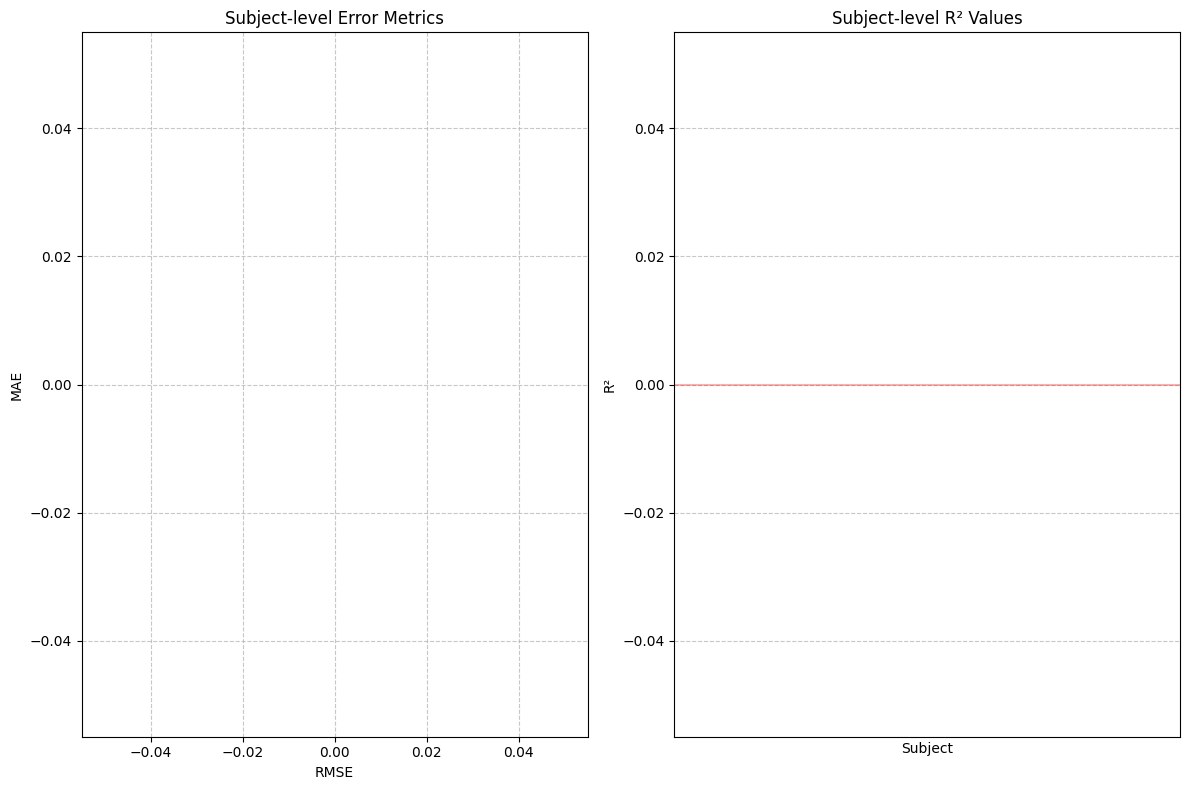

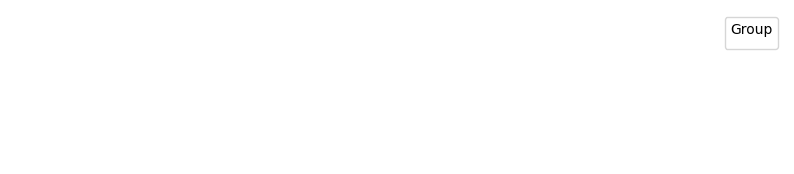

Average Coefficients Across All Profiles:
-----------------------------------------
Intercept: 15.579705 ± 1.725325 (Range: 10.660889 to 19.983620)
Frequency (x1): -0.000046 ± 0.000126 (Range: -0.000423 to 0.000119)
Amplitude (x3): 1.078668 ± 1.333283 (Range: -0.894315 to 7.077168)
Version (v1): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)
Version (v2): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)
Frequency*Amplitude: -0.000037 ± 0.000123 (Range: -0.000693 to 0.000099)
Frequency*Version (v1): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)
Frequency*Version (v2): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)
Amplitude*Version (v1): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)
Amplitude*Version (v2): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)
Freq*Amp*Version (v1): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)
Freq*Amp*Version (v2): 0.000000 ± 0.000000 (Range: 0.000000 to 0.000000)

Average Intercept: 15.5797 ± 1.7253

Coefficient DataFrame:


Feature       Mean       Std     Median        Min  \
0                Intercept  15.579705  1.725325  15.440080  10.660889   
1           Frequency (x1)  -0.000046  0.000126  -0.000006  -0.000423   
2           Amplitude (x3)   1.078668  1.333283   0.844509  -0.894315   
3             Version (v1)   0.000000  0.000000   0.000000   0.000000   
4             Version (v2)   0.000000  0.000000   0.000000   0.000000   
5      Frequency*Amplitude  -0.000037  0.000123  -0.000009  -0.000693   
6   Frequency*Version (v1)   0.000000  0.000000   0.000000   0.000000   
7   Frequency*Version (v2)   0.000000  0.000000   0.000000   0.000000   
8   Amplitude*Version (v1)   0.000000  0.000000   0.000000   0.000000   
9   Amplitude*Version (v2)   0.000000  0.000000   0.000000   0.000000   
10   Freq*Amp*Version (v1)   0.000000  0.000000   0.000000   0.000000   
11   Freq*Amp*Version (v2)   0.000000  0.000000   0.000000   0.000000   

          Max  
0   19.983620  
1    0.000119  
2    7.077168  
3    0.000000  
4    0.000000  
5    0.000099  
6    0.000000  
7    0.000000  
8    0.000000  
9    0.000000  
10   0.000000  
11   0.000000

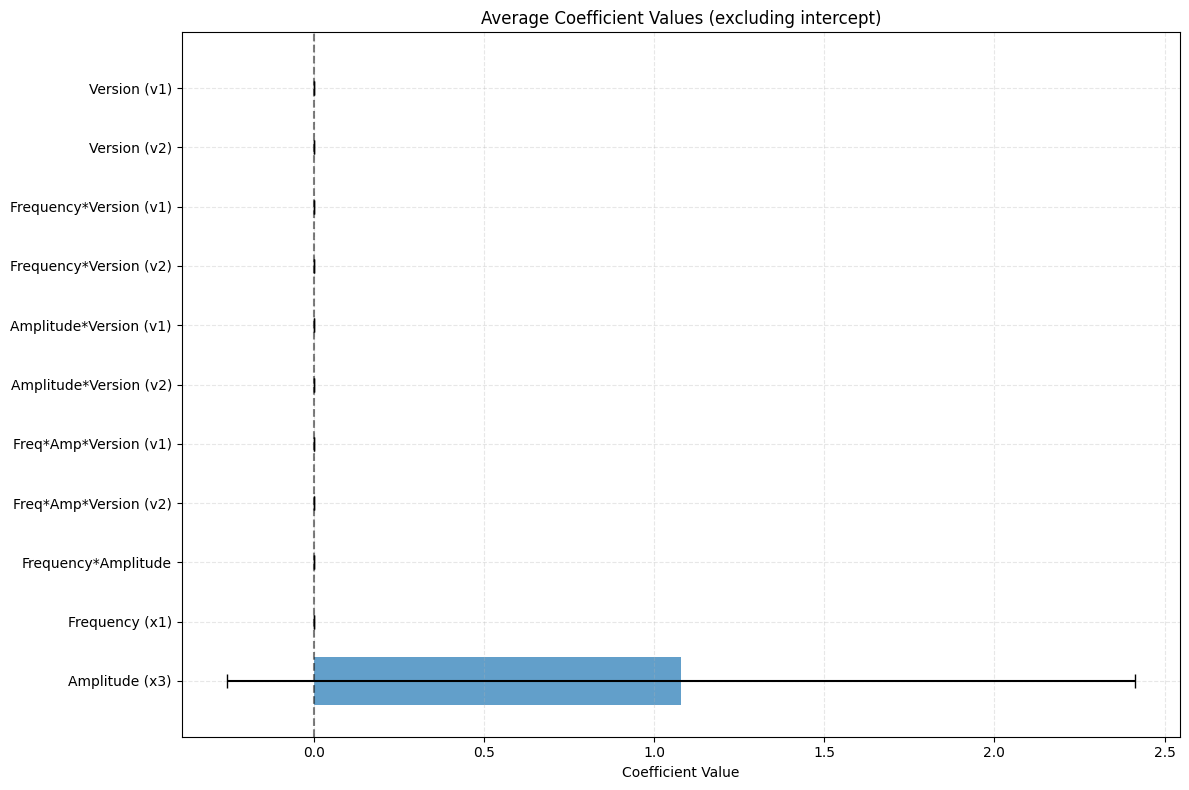

In [ ]:
def analyze_model_coefficients(profiles):
    """
    Analyze coefficients across all Bayesian profile models
    
    Parameters:
    profiles (dict): Dictionary of BayesianProfile_x1x3x4 objects
    
    Returns:
    dict: Dictionary with average coefficients and other statistics
    """
    # Store all coefficients
    all_coefficients = []
    
    # Collect coefficient arrays from all profiles
    for profile_key, profile in profiles.items():
        all_coefficients.append(profile.mean_y1)
    
    # Convert to numpy array
    coefficient_array = np.array(all_coefficients)
    
    # Calculate statistics
    mean_coefficients = np.mean(coefficient_array, axis=0)
    std_coefficients = np.std(coefficient_array, axis=0)
    median_coefficients = np.median(coefficient_array, axis=0)
    min_coefficients = np.min(coefficient_array, axis=0)
    max_coefficients = np.max(coefficient_array, axis=0)
    
    # Feature names based on your model structure
    feature_names = [
        'Intercept',
        'Frequency (x1)',
        'Amplitude (x3)',
        'Version (v1)',
        'Version (v2)',
        'Frequency*Amplitude',
        'Frequency*Version (v1)',
        'Frequency*Version (v2)',
        'Amplitude*Version (v1)',
        'Amplitude*Version (v2)',
        'Freq*Amp*Version (v1)',
        'Freq*Amp*Version (v2)'
    ]
    
    # Print results in a nice format
    print("Average Coefficients Across All Profiles:")
    print("-----------------------------------------")
    for i, feature in enumerate(feature_names):
        print(f"{feature}: {mean_coefficients[i]:.6f} ± {std_coefficients[i]:.6f} (Range: {min_coefficients[i]:.6f} to {max_coefficients[i]:.6f})")
    
    # Create a DataFrame for easy analysis
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean': mean_coefficients,
        'Std': std_coefficients,
        'Median': median_coefficients,
        'Min': min_coefficients,
        'Max': max_coefficients
    })
    
    # Plot the average coefficients (excluding intercept for better scaling)
    plt.figure(figsize=(12, 8))
    
    # Sort by absolute value of mean coefficient (excluding intercept)
    sorted_indices = np.argsort(np.abs(mean_coefficients[1:]))[::-1] + 1
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_means = mean_coefficients[sorted_indices]
    sorted_std = std_coefficients[sorted_indices]
    
    plt.barh(sorted_features, sorted_means, xerr=sorted_std, capsize=5, alpha=0.7)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Coefficient Value')
    plt.title('Average Coefficient Values (excluding intercept)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Display the intercept separately
    print(f"\nAverage Intercept: {mean_coefficients[0]:.4f} ± {std_coefficients[0]:.4f}")
    
    return {
        'mean': mean_coefficients,
        'std': std_coefficients,
        'median': median_coefficients,
        'min': min_coefficients,
        'max': max_coefficients,
        'dataframe': coef_df
    }

# Use the function with your profiles
coefficient_analysis = analyze_model_coefficients(subjects_profiles_TTsplit_x1x3x4)

# You can access the result as a DataFrame
coefficient_df = coefficient_analysis['dataframe']
# print("\nCoefficient DataFrame:")
# coefficient_df

In [559]:
for x in np.unique(final_clean_strained_grouped_pos['Group']):
    print(x)

101dB 24h post
14wks ctrl
14wks ctrl 
6wks ctrl
8wks ctrl
90dB 0h post
90dB 24h post
90dB 2w post
94dB 0h post
94dB 0h post 
94dB 24h post
94dB 2w post
94dB 8wks post
98dB 24h post
98dB 2w post
98dB 8wks post


## With interactions, no vx

In [279]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class BayesianProfile_v4:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None): #PROBLEM WITH V2: priors were set up PER subject when I have them best per freq/db. Updated in add_obs function
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3) NOW ADDING IN X4 AS VX
        # Will need experimentation to understand the predictive power of interactive terms
        self.n_params = 24
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y1

        if prior_mean_y2 is None:
            self.mean_y2 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y2
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        if prior_cov_y2 is None:
            self.cov_y2 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y2 = prior_cov_y2
        
        # self.x4_categories = x4_categories

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        self.y2_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        self.rmse_history_y2 = []


    # def encode_x4(self, x4):
    #     """
    #     Encode categorical x4 value using one-hot encoding
    #     """
    #     if isinstance(x4, pd.Series):
    #         x4 = x4.iloc[0]  # Take first value if it's a series
        
    #     # Create one-hot encoding
    #     encoding = np.zeros(len(self.x4_categories))
    #     if x4 in self.x4_categories:
    #         encoding[self.x4_categories.index(x4)] = 1
    #     return encoding
        
    def add_observation_y1(self, x1, x2, x3, y1, noise_var=1.0,prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        # print(f"x4 BEFORE passed to encoder function: {x4}")
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        # x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y1_value = float(y1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            # x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            # x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            # x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1)       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            # ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(y1_value)
        
        # Compute Kalman gain
        K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)

        innovation = y1_value -float(X @ self.mean_y1)
        self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
        self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)

        # Update RMSE
        y1_pred = self.predict_y1(x1[0,0], x2[0,0], x3[0,0]) #x4
        rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
                               [self.predict_y1(x[1], x[2], x[3]) for x in self.X_history])**2)) #x[4]
        self.rmse_history_y1.append(rmse)

    def add_observation_y2(self, x1, x2, x3, y2, noise_var=1.0, prior_mean_y2=None, prior_cov_y2=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        # x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y2_value = float(y2)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            # x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            # x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            # x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1)     # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            # ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y2_history.append(y2_value)
        
        # Kalman gain
        K = self.cov_y2 @ X.T @ np.linalg.inv(X @ self.cov_y2 @ X.T + noise_var)

        innovation = y2_value -float(X @ self.mean_y1)
        self.mean_y2 = self.mean_y2 + (K.flatten() * innovation)
        self.cov_y2 = self.cov_y2 - (K @ X @ self.cov_y2)
        
        # Update RMSE
        y2_pred = self.predict_y2(x1, x2, x3)
        rmse = np.sqrt(np.mean((np.array(self.y2_history) - 
                               [self.predict_y2(x[1], x[2], x[3]) for x in self.X_history])**2))
        self.rmse_history_y2.append(rmse)
    
    def predict_y1(self, x1, x2, x3):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        # x1 = np.asarray(x1).reshape(-1)
        # x2 = np.asarray(x2).reshape(-1)
        # x3 = np.asarray(x3).reshape(-1)
        # x4_encoded = self.encode_x4(x4)
        
        # # Make sure all inputs have the same first dimension
        # n = max(x1.size, x2.size, x3.size)
        # if x1.size == 1:
        #     x1 = np.repeat(x1, n)
        # if x2.size == 1:
        #     x2 = np.repeat(x2, n)
        # if x3.size == 1:
        #     x3 = np.repeat(x3, n)

        # X = np.column_stack((
        #     np.ones_like(x1), x1, x2, x3, x4_encoded,
        #     x1*x2, x1*x3, np.outer(x1, x4_encoded).reshape(x1.size, -1), 
        #     x2*x3, np.outer(x2, x4_encoded).reshape(x2.size, -1), 
        #     np.outer(x3, x4_encoded).reshape(x3.size, -1),
        #     x1*x2*x3, 
        #     np.outer(x1*x2, x4_encoded).reshape((x1*x2).size, -1),
        #     np.outer(x1*x3, x4_encoded).reshape((x1*x3).size, -1),
        #     np.outer(x2*x3, x4_encoded).reshape((x2*x3).size, -1),
        #     np.outer(x1*x2*x3, x4_encoded).reshape((x1*x2*x3).size, -1)
        # ))
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        # x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            # x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            # x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1)       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            # ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        
        return X @ self.mean_y1
    
    def predict_y2(self, x1, x2, x3):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        # x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            # x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            # x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            # x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1)       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            # ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)

        return X @ self.mean_y2
    
    def predict_with_uncertainty_y1(self, x1, x2, x3):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        # x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            # x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            # x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            # x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1)       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            # ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        return float(pred), float(std)
    
    def predict_with_uncertainty_y2(self, x1, x2, x3):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        # x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            # x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            # x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            # x2.T @ x4_encoded,                # 2
            # x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1)       # 1
            # ((x1*x2).T @ x4_encoded),        # 2
            # ((x1*x3).T @ x4_encoded),        # 2
            # ((x2*x3).T @ x4_encoded),        # 2
            # ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y2
        std = np.sqrt(X @ self.cov_y2 @ X.T)
        return float(pred), float(std)
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        return plt.gcf()
    
    def plot_learning_curve_y2(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y2, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - IHCs Prediction')
        return plt.gcf()
    
def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
    """
    Plot RMSE learning curves for multiple Bayesian profiles
    
    Parameters:
    profiles (list): List of BayesianProfile_v2 objects
    profile_names (list): Optional list of names for each profile
    metric (str): Either 'y1' or 'y2' to specify which metric to plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    plt.figure(figsize=figsize)
    
    # Generate colors using a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
    # If no profile names provided, create default ones
    if profile_names is None:
        profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
    # Plot each profile's learning curve
    for profile, name, color in zip(profiles, profile_names, colors):
        if metric == 'y1':
            rmse_history = profile.rmse_history_y1
            title = 'Learning Curves - Average Synapses to IHC Prediction'
        else:
            rmse_history = profile.rmse_history_y2
            title = 'Learning Curves - IHCs Prediction'
            
        plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
                markersize=4, linewidth=2)
    
    plt.xlabel('Number of Observations')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

In [399]:
# subjects_profiles_TTsplit_v4 = {}

# for subject in np.unique(X_train1['Subject']):
#     profile_key = f"subject_{subject}"
#     subjects_profiles_TTsplit_v4[profile_key] = BayesianProfile_v4()

#     for freq in np.unique(X_train1[X_train1['Subject']==subject]['Freq(Hz) (x1)']):
#         for db in np.unique(X_train1[X_train1['Subject']==subject]['Level(dB) (x2)']):
#             for amp in np.unique(X_train1[X_train1['Subject']==subject]['Amplitude (x3)']):
#                 # for vx in np.unique(X_train1[X_train1['Subject']==subject]['vx (x4)']):
#                 record_X = X_train1[(X_train1['Subject']==subject) & (X_train1['Freq(Hz) (x1)'] == freq) & (X_train1['Level(dB) (x2)'] == db) & (X_train1['Amplitude (x3)'] == amp)]
#                 idx = record_X.index
                
#                 if len(y1_train.loc[idx]) == 2:
#                     y1_0 = float(y1_train.loc[idx].values[0])
#                     subjects_profiles_TTsplit_v4[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, y1=y1_0)
#                     print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, dx={idx}, y1={y1_0} - loaded")
#                     y1_1 = float(y1_train.loc[idx].values[1])
#                     subjects_profiles_TTsplit_v4[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, y1=y1_1)
#                     print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, idx={idx}, y1={y1_1} - loaded")


#                 elif len(y1_train.loc[idx]) == 1:
#                     y1 = y1_train.loc[idx].values[0]
#                     subjects_profiles_TTsplit_v4[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, y1=y1)
#                     print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, idx={idx}, y1={y1} - loaded")

#                     # print(f"freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}")



## With strains, interactions, vx

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class BayesianProfile_v5:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None, x4_categories=['v1', 'v2'], x5_categories = ['CBA/CaJ', 'C57B6B8']): #PROBLEM WITH V2: priors were set up PER subject when I have them best per freq/db. Updated in add_obs function
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3) NOW ADDING IN X4 AS VX
        # Will need experimentation to understand the predictive power of interactive terms
        self.n_params = 24
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y1

        if prior_mean_y2 is None:
            self.mean_y2 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y2
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        if prior_cov_y2 is None:
            self.cov_y2 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y2 = prior_cov_y2
        
        self.x4_categories = x4_categories
        self.x5_categories = x5_categories

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        self.y2_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        self.rmse_history_y2 = []


    def encode_x4(self, x4):
        """
        Encode categorical x4 value using one-hot encoding
        """
        if isinstance(x4, pd.Series):
            x4 = x4.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x4_categories))
        if x4 in self.x4_categories:
            encoding[self.x4_categories.index(x4)] = 1
        return encoding
    
    def encode_x5(self, x5):
        if isinstance(x5, pd.Series):
            x5 = x5.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x5_categories))
        if x5 in self.x5_categories:
            encoding[self.x5_categories.index(x5)] = 1
        return encoding
        
    def add_observation_y1(self, x1, x2, x3, x4, x5, y1, noise_var=1.0,prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        # print(f"x4 BEFORE passed to encoder function: {x4}")
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        y1_value = float(y1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded),
            x5_encoded      # 2
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(y1_value)
        
        # Compute Kalman gain
        K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)

        innovation = y1_value -float(X @ self.mean_y1)
        self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
        self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)

        # Update RMSE
        y1_pred = self.predict_y1(x1[0,0], x2[0,0], x3[0,0], x4)
        rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
                               [self.predict_y1(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y1.append(rmse)

    def add_observation_y2(self, x1, x2, x3, x4, x5, y2, noise_var=1.0, prior_mean_y2=None, prior_cov_y2=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        y2_value = float(y2)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded),      # 2
            x5_encoded
        ]
        
        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y2_history.append(y2_value)
        
        # Kalman gain
        K = self.cov_y2 @ X.T @ np.linalg.inv(X @ self.cov_y2 @ X.T + noise_var)

        innovation = y2_value -float(X @ self.mean_y1)
        self.mean_y2 = self.mean_y2 + (K.flatten() * innovation)
        self.cov_y2 = self.cov_y2 - (K @ X @ self.cov_y2)
        
        # Update RMSE
        y2_pred = self.predict_y2(x1, x2, x3, x4)
        rmse = np.sqrt(np.mean((np.array(self.y2_history) - 
                               [self.predict_y2(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y2.append(rmse)
    
    def predict_y1(self, x1, x2, x3, x4, x5):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        # x1 = np.asarray(x1).reshape(-1)
        # x2 = np.asarray(x2).reshape(-1)
        # x3 = np.asarray(x3).reshape(-1)
        # x4_encoded = self.encode_x4(x4)
        
        # # Make sure all inputs have the same first dimension
        # n = max(x1.size, x2.size, x3.size)
        # if x1.size == 1:
        #     x1 = np.repeat(x1, n)
        # if x2.size == 1:
        #     x2 = np.repeat(x2, n)
        # if x3.size == 1:
        #     x3 = np.repeat(x3, n)

        # X = np.column_stack((
        #     np.ones_like(x1), x1, x2, x3, x4_encoded,
        #     x1*x2, x1*x3, np.outer(x1, x4_encoded).reshape(x1.size, -1), 
        #     x2*x3, np.outer(x2, x4_encoded).reshape(x2.size, -1), 
        #     np.outer(x3, x4_encoded).reshape(x3.size, -1),
        #     x1*x2*x3, 
        #     np.outer(x1*x2, x4_encoded).reshape((x1*x2).size, -1),
        #     np.outer(x1*x3, x4_encoded).reshape((x1*x3).size, -1),
        #     np.outer(x2*x3, x4_encoded).reshape((x2*x3).size, -1),
        #     np.outer(x1*x2*x3, x4_encoded).reshape((x1*x2*x3).size, -1)
        # ))
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded),      # 2
            x5_encoded
        ]

        X = np.hstack(arrays_to_stack)
        
        return X @ self.mean_y1
    
    def predict_y2(self, x1, x2, x3, x4, x5):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded),      # 2
            x5_encoded
        ]

        X = np.hstack(arrays_to_stack)

        return X @ self.mean_y2
    
    def predict_with_uncertainty_y1(self, x1, x2, x3, x4, x5):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded),      # 2
            x5_encoded
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        return float(pred), float(std)
    
    def predict_with_uncertainty_y2(self, x1, x2, x3, x4, x5):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded),      # 2
            x5_encoded
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y2
        std = np.sqrt(X @ self.cov_y2 @ X.T)
        return float(pred), float(std)
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        return plt.gcf()
    
    def plot_learning_curve_y2(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y2, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - IHCs Prediction')
        return plt.gcf()
    
def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
    """
    Plot RMSE learning curves for multiple Bayesian profiles
    
    Parameters:
    profiles (list): List of BayesianProfile_v2 objects
    profile_names (list): Optional list of names for each profile
    metric (str): Either 'y1' or 'y2' to specify which metric to plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    plt.figure(figsize=figsize)
    
    # Generate colors using a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
    # If no profile names provided, create default ones
    if profile_names is None:
        profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
    # Plot each profile's learning curve
    for profile, name, color in zip(profiles, profile_names, colors):
        if metric == 'y1':
            rmse_history = profile.rmse_history_y1
            title = 'Learning Curves - Average Synapses to IHC Prediction'
        else:
            rmse_history = profile.rmse_history_y2
            title = 'Learning Curves - IHCs Prediction'
            
        plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
                markersize=4, linewidth=2)
    
    plt.xlabel('Number of Observations')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

In [ ]:
from sklearn.model_selection import train_test_split

X_num = final_clean[['Subject','Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']

X_train1, X_test1, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
subjects_profiles_TTsplit_v5 = {}

for subject in np.unique(X_train1['Subject']):
    profile_key = f"subject_{subject}"
    subjects_profiles_TTsplit_v5[profile_key] = BayesianProfile_v5()

    for freq in np.unique(X_train1[X_train1['Subject']==subject]['Freq(Hz) (x1)']):
        for db in np.unique(X_train1[X_train1['Subject']==subject]['Level(dB) (x2)']):
            for amp in np.unique(X_train1[X_train1['Subject']==subject]['Amplitude (x3)']):
                for vx in np.unique(X_train1[X_train1['Subject']==subject]['vx (x4)']):
                    record_X = X_train1[(X_train1['Subject']==subject) & (X_train1['Freq(Hz) (x1)'] == freq) & (X_train1['Level(dB) (x2)'] == db) & (X_train1['Amplitude (x3)'] == amp) & (X_train1['vx (x4)']==vx)]
                    idx = record_X.index
                    
                    if len(y1_train.loc[idx]) == 2:
                        if vx == 0:
                            y1_0 = float(y1_train.loc[idx].values[0])
                            subjects_profiles_TTsplit_v5[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, x4=vx, y1=y1_0)
                            print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}, y1={y1_0} - loaded")
                        elif vx == 1:
                            y1_1 = float(y1_train.loc[idx].values[1])
                            subjects_profiles_TTsplit_v5[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, x4=vx, y1=y1_1)
                            print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}, y1={y1_1} - loaded")


                    elif len(y1_train.loc[idx]) == 1:
                        y1 = y1_train.loc[idx].values[0]
                        subjects_profiles_TTsplit_v5[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, x4=vx, y1=y1)
                        print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}, y1={y1} - loaded")

                        # print(f"freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}")



In [ ]:
subjects = []
RMSES = []
freqs = []
dbs = []
amps = []
vxs = []
ys = []
y_preds = []

for subject in np.unique(X_test1['Subject']):
    profile_key = f"subject_{subject}"
    subject_rmses = []
    for freq in np.unique(X_test1[X_test1['Subject']==subject]['Freq(Hz) (x1)']):
        for db in np.unique(X_test1[X_test1['Subject']==subject]['Level(dB) (x2)']):
            for amp in np.unique(X_test1[X_test1['Subject']==subject]['Amplitude (x3)']):
                for vx in np.unique(X_test1[X_test1['Subject']==subject]['vx (x4)']):
                    record_X = X_test1[(X_test1['Subject']==subject) & (X_test1['Freq(Hz) (x1)'] == freq) & (X_test1['Level(dB) (x2)'] == db) & (X_test1['Amplitude (x3)'] == amp) & (X_test1['vx (x4)']==vx)]
                    idx = record_X.index
                    
                    if len(y1_test.loc[idx]) == 2:
                        if vx == 0:
                            y1_v1 = float(y1_test.loc[idx].values[0])
                            y1_v1_pred = subjects_profiles_TTsplit[profile_key].predict_y1(x1=freq, x2=db, x3=amp, x4=vx)
                            RMSE = np.sqrt(np.mean((y1_v1-y1_v1_pred)**2))
                            subjects.append(subject)
                            freqs.append(freq)
                            dbs.append(db)
                            amps.append(amp)
                            vxs.append(vx)
                            ys.append(y1_v1)
                            y_preds.append(y1_v1_pred)
                            RMSES.append(RMSE)
                            # print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx} - predicted y1={y1_v1_pred}")

                        elif vx == 1:
                            y1_v2 = float(y1_test.loc[idx].values[1])
                            y1_v2_pred = subjects_profiles_TTsplit[profile_key].predict_y1(x1=freq, x2=db, x3=amp, x4=vx)
                            RMSE = np.sqrt(np.mean((y1_v2-y1_v2_pred)**2))
                            subjects.append(subject)
                            freqs.append(freq)
                            dbs.append(db)
                            amps.append(amp)
                            vxs.append(vx)
                            ys.append(y1_v2)
                            y_preds.append(y1_v2_pred)
                            RMSES.append(RMSE)
                            # print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx} - predicted y1={y1_v2_pred}")

                    elif len(y1_test.loc[idx]) == 1:
                        y1 = float(y1_test.loc[idx].values[0])
                        y1_pred = subjects_profiles_TTsplit[profile_key].predict_y1(x1=freq, x2=db, x3=amp, x4=vx)
                        RMSE = np.sqrt(np.mean((y1-y1_pred)**2))
                        subjects.append(subject)
                        freqs.append(freq)
                        dbs.append(db)
                        amps.append(amp)
                        vxs.append(vx)
                        ys.append(y1)
                        y_preds.append(y1_pred)
                        RMSES.append(RMSE)
                        # print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx} - predicted y1={y1_pred}")

test_results = {
    'Subject': subjects, 
    'FreqHz (x1)': freqs, 
    'LeveldB (x2)': dbs, 
    'Amplitude (x3)': amps, 
    'vx (x4)': vxs,
    'Synapses to IHC (y1)' : ys,
    'y1 Predictions' : y_preds,
    'RMSEs': RMSES
}

results_df = pd.DataFrame(data=test_results)


In [ ]:
listnp.unique(final_clean_strained_grouped['Amplitude (x3)'])

[np.float64(10.0),
 np.float64(15.0),
 np.float64(20.0),
 np.float64(25.0),
 np.float64(30.0),
 np.float64(35.0),
 np.float64(40.0),
 np.float64(45.0),
 np.float64(50.0),
 np.float64(55.0),
 np.float64(60.0),
 np.float64(65.0),
 np.float64(70.0),
 np.float64(75.0),
 np.float64(80.0)]

# Split Model Results by Experimental Group

In [383]:
def display_rf_results_by_external_feature(rf_model, X_test, y_test, external_df, id_column, feature_name, index_map=None):
    """
    Display Random Forest results grouped by a feature not used in training
    
    Parameters:
    -----------
    rf_model: trained Random Forest model
    X_test: test features DataFrame
    y_test: test target Series/array
    external_df: DataFrame containing the external feature
    id_column: column name in external_df that contains the identifier
    feature_name: name of the external feature to group by
    index_map: optional Series or dict mapping index positions to id_column values
    """
    # Get predictions
    y_pred = rf_model.predict(X_test)
    
    # Create a results DataFrame
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Abs_Error': np.abs(y_test - y_pred),
    })
    
    # If we have an index map, use it to link results to external data
    if index_map is not None:
        # Map index to Subject ID
        results_df[id_column] = results_df.index.map(index_map)
    elif isinstance(y_test, pd.Series) and id_column in y_test.index.names:
        # If id_column is in the index of y_test, extract it
        results_df[id_column] = y_test.index.get_level_values(id_column)
    elif isinstance(X_test, pd.DataFrame) and id_column in X_test.index.names:
        # If id_column is in the index of X_test, extract it
        results_df[id_column] = X_test.index.get_level_values(id_column)
    else:
        print(f"Warning: Cannot find {id_column} in the data.")
        print("Please provide an index_map that maps test data indices to {id_column} values.")
        print("Example: index_map = {0: 'Subject1', 1: 'Subject2', ...}")
        return None
    
    # Convert id columns to the same type
    results_df[id_column] = results_df[id_column].astype(str)
    external_df = external_df.copy()  # Create a copy to avoid modifying the original
    external_df[id_column] = external_df[id_column].astype(str)
    
    # Join with external feature
    merged_df = results_df.merge(
        external_df[[id_column, feature_name]], 
        on=id_column,
        how='left'
    )
    
    # Check if we have matching data
    if len(merged_df) == 0 or merged_df[feature_name].isna().all():
        print("No matching data found between test data and external_df on column:", id_column)
        return None
    
    # Group by the external feature
    grouped_results = merged_df.groupby(feature_name).agg({
        'Actual': 'mean',
        'Predicted': 'mean',
        'Error': 'mean',
        'Abs_Error': ['mean', 'std', 'count']
    })
    
    # Flatten MultiIndex columns
    grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]
    
    # Plot results
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Actual vs Predicted by feature
    grouped_results[['Actual_mean', 'Predicted_mean']].plot(
        kind='bar', 
        ax=axes[0],
        title=f'Actual vs Predicted by {feature_name}'
    )
    axes[0].set_ylabel('Value')
    axes[0].set_xlabel(feature_name)
    axes[0].legend(['Actual', 'Predicted'])
    
    # Plot 2: Error by feature
    ax2 = axes[1]
    bars = ax2.bar(
        range(len(grouped_results)), 
        grouped_results['Abs_Error_mean'],
        yerr=grouped_results['Abs_Error_std'],
        capsize=5,
        color='orange'
    )
    
    # Add sample size as text on bars
    for i, bar in enumerate(bars):
        count = grouped_results['Abs_Error_count'].iloc[i]
        ax2.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + grouped_results['Abs_Error_std'].iloc[i] + 0.02,
            f'n={count}',
            ha='center'
        )
    
    ax2.set_title(f'Absolute Error by {feature_name}')
    ax2.set_ylabel('Absolute Error')
    ax2.set_xlabel(feature_name)
    ax2.set_xticks(range(len(grouped_results)))
    ax2.set_xticklabels(grouped_results.index)
    
    plt.tight_layout()
    plt.show()
    
    return grouped_results

# Create index_map - maps test data indices to Subject IDs
# Option 1: If you have a lookup DataFrame with this information
index_map = {}
for i, idx in enumerate(X_test.index):
    index_map[idx] = final_clean_strained['Subject'].iloc[i]  # subjects is a list/array of subject IDs

# Works but need to first stratify by group!!!
# display_rf_results_by_external_feature(rf_model, X_test, y1_test, final_clean_strained, 'Subject', 'Group', index_map=index_map)